In [ ]:
%load_ext autoreload
%autoreload

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

def smile_to_bit(smile):
  mol = Chem.MolFromSmiles(smile)
  return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096, useChirality=True)

def morgan_bits(smiles):
  paws = []
  for smile in smiles:
    paws.append(np.asarray(smile_to_bit(smile)))
  return paws

def morgan_bits_from_df(smiles, prefix):
  df = pd.DataFrame(morgan_bits(smiles))
  columns = [f'{prefix}_{i}' for i in df.columns]
  df.columns = columns
  return df

def clean_training_data():
    '''Script for cleaning the training data from overlappping 
       co-crystals that exist in the validation data'''

    csd_dataset = pd.read_csv('/content/all_validation_sets.csv')
    df1 = csd_dataset.smiles1.values[:] 
    df2 = csd_dataset.smiles2.values[:] 
    df_csd = pd.concat([morgan_bits_from_df(df1[:], 'bits_1'), morgan_bits_from_df(df2[:], 'bits_2')], axis=1)
    
    validation_data = pd.read_csv('/content/csd_cocrystals2020.csv')
    validation_smiles1 = validation_data['smiles1'].values
    validation_smiles2 = validation_data['smiles2'].values
    df_validation = pd.concat([morgan_bits_from_df(validation_smiles1[:], 'bits_1'), morgan_bits_from_df(validation_smiles2[:], 'bits_2')], axis=1)

    df_csd=df_csd.drop_duplicates(keep='last')
    print(df_csd.shape)
    validation_sets = df_validation
    validation_sets=validation_sets.drop_duplicates(keep='last')
    print(validation_sets.shape)
    data_all =  pd.concat([df_csd, validation_sets], ignore_index=True)
    print(data_all.shape)
    data_all = data_all.drop_duplicates(keep='last')
    print(data_all.shape)
    df_csd = data_all.iloc[ :7109 , :]  
    return df_csd




ModuleNotFoundError: ignored

In [ ]:
clean_training_data()

UnicodeDecodeError: ignored

# Import the data

In [ ]:
# Import the main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Evalute on the RC data
# Import evaluation libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rdkit-pypi

     |████████████████████████████████| 20.6 MB 1.4 MB/s 


# Fingerprints as representation

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
m1 = Chem.MolFromSmiles('Cc1ccccc1')
fp1 = AllChem.GetMorganFingerprintAsBitVect(m1,2, 4096)
np.asarray(fp1).shape

(4096,)

In [ ]:
cocrystal = pd.read_csv('/content/cocrystals2020_clean_functionality.csv', encoding='latin')
#('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/training_data/smiles/train_data.csv')
#
#('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/training_data/smiles/train_data.csv')
cocrystals=cocrystal.iloc[:-1,:]
cocrystals

csd_id  ... group
0     IANNOB  ...     1
1     CLAHMB  ...     1
2     MTHMAD  ...     2
3     PERFAN  ...     1
4     ANCTNB  ...     1
...      ...  ...   ...
7473  UKIFUS  ...     2
7474  UKITEQ  ...     2
7475  UKITUG  ...     2
7476  UKIVIW  ...     2
7477  ULECEW  ...     2

[7478 rows x 7 columns]

In [ ]:
def smile_to_paw(smile):
  mol = Chem.MolFromSmiles(smile)
  return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096, useChirality=True)
  #MHFPEncoder.secfp_from_smiles(smile, length=2048, radius=3, rings=True, kekulize=True, sanitize=False)
  #AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048, useChirality=True)  
  #MHFPEncoder.secfp_from_smiles(smile, length=2048, radius=3, rings=True, kekulize=True, sanitize=False)
  #MACCSkeys.GenMACCSKeys(mol)
  #AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=4096, useChirality=True)  

def kat_paws(smiles):
  paws = []
  for smile in smiles:
    paws.append(np.asarray(smile_to_paw(smile)))
  return paws

def kat_paws_from_df(smiles, prefix):
  df = pd.DataFrame(kat_paws(smiles))
  columns = [f'{prefix}_{i}' for i in df.columns]
  df.columns = columns
  return df

In [ ]:
cocrystals= pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/csd_training_set.csv')
train_cocrystal_smiles = set(np.concatenate([cocrystals.smiles1.values, cocrystals.smiles2.values]))
print(len(train_cocrystal_smiles))
# Validation co-crystal data
validation_data = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/all_validation_sets.csv')
validation_data_smiles = set(np.concatenate([validation_data.smiles1.values, validation_data.smiles2.values]))
print(len(validation_data_smiles))

4343
705


In [ ]:
validation_data

Co-crystal Dataset  ...                                    smiles2 Unnamed: 4
0              1   grecu  ...             COc1ccc(cc1)C1=NN2C=C(C)N=C2S1        NaN
1              1   grecu  ...                        CC1=NN2C=C(C)N=C2S1        NaN
2              1   grecu  ...                         c1cc(ccn1)c1ccncc1        NaN
3              1   grecu  ...                               NC1=CN=CC=C1        NaN
4              1   grecu  ...                                  Nc1ccccn1        NaN
...          ...     ...  ...                                        ...        ...
2372           0     MOP  ...                         NC(CCC(O)=O)C(O)=O        NaN
2373           0     MOP  ...                                  N1C=CN=C1        NaN
2374           0     MOP  ...                             NC(=O)c1ccncc1        NaN
2375           0     MOP  ...             OC(=O)c1cc(cc(c1)C(O)=O)C(O)=O        NaN
2376           0     MOP  ...  C1=C(C(=CC(=C1C(=O)O)C(=O)O)C(=O)O)C(=O)O        NaN

[2377 rows x 5 columns]

In [ ]:
val_data_all = pd.concat([kat_paws_from_df(validation_data.smiles1.values[:], 'paws_1'), kat_paws_from_df(validation_data.smiles2.values[:], 'paws_2')], axis=1)
val_data = val_data_all.drop_duplicates()


In [ ]:
val_label = validation_data['Co-crystal']
labels= val_label.loc[val_data.index]

In [ ]:
val_data

paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
1            0         0         0  ...            0            0            0
2            0         0         0  ...            0            0            0
3            0         0         0  ...            0            0            0
4            0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
2372         0         0         0  ...            0            0            0
2373         0         0         0  ...            0            0            0
2374         0         0         0  ...            0            0            0
2375         0         0         0  ...            0            0            0
2376         0         0         0  ...            0            0            0

[2192 rows x 8192 columns]

In [ ]:
df1 = cocrystals.smiles1.values[:] 
df2 = cocrystals.smiles2.values[:] 

In [ ]:
df_paws = pd.concat([kat_paws_from_df(df1[:], 'paws_1'), kat_paws_from_df(df2[:], 'paws_2')], axis=1)
df_paws

paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
1            0         0         0  ...            0            0            0
2            0         0         0  ...            0            0            0
3            0         0         0  ...            0            0            0
4            0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
7070         0         0         0  ...            0            0            0
7071         0         0         0  ...            0            0            0
7072         0         0         0  ...            0            0            0
7073         0         0         0  ...            0            0            0
7074         0         0         0  ...            0            0            0

[7075 rows x 8192 columns]

In [ ]:
# Grecu data

grecu = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/validation_set/public_available_data/PublicallyAvalibledata.csv', encoding='latin1')
grecu=grecu[grecu['Name 1']!= 'desloratadine' ]
grecu=grecu[grecu['Name 1']!= 'loratadine' ]
label= grecu['Co-crystal']
grecu_smiles1 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in grecu['CCDC Smiles1'].values ] #grecu['CCDC Smiles1'].values #
grecu_smiles2 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in grecu['CCDC Smiles2'].values ] #grecu['CCDC Smiles2'].values #


grecu_df = pd.concat([grecu['Name 1'], grecu['Name2'], kat_paws_from_df(grecu['CCDC Smiles1'].values, 'paws_1'), kat_paws_from_df(grecu['CCDC Smiles2'].values, 'paws_2')], axis=1)

In [ ]:
# Akeroy data deloratadine-loratadine
akeroy = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/validation_set/public_available_data/PublicallyAvalibledata.csv', encoding='latin1')
akeroy_des=akeroy[akeroy['Name 1'] == 'desloratadine' ]
akeroy_label_des= akeroy_des['Co-crystal']
akeroy_lo =akeroy[akeroy['Name 1'] == 'loratadine' ]
akeroy_label_lo= akeroy_lo['Co-crystal']
akeroy = pd.concat([akeroy_des ,akeroy_lo], ignore_index=True)
akeroy_label= pd.concat([akeroy_label_des ,akeroy_label_lo], ignore_index=True)

aker_smiles1 =akeroy['CCDC Smiles1'].values # [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in akeroy['CCDC Smiles1'].values ] #
aker_smiles2 = akeroy['CCDC Smiles2'].values # [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in akeroy['CCDC Smiles2'].values ] #

akeroy_df = pd.concat([akeroy['Name 1'], akeroy['Name2'], kat_paws_from_df(aker_smiles1, 'paws_1'), kat_paws_from_df(aker_smiles2, 'paws_2')], axis=1)
akeroy_df 

Name 1                        Name2  ...  paws_2_4094  paws_2_4095
0   desloratadine  3-Hydroxy-2-naphthoic acid   ...            0            0
1   desloratadine       4-Hydroxybenzoic acid   ...            0            0
2   desloratadine                 Adipic acid   ...            0            0
3   desloratadine                    Apigenin   ...            0            0
4   desloratadine        Benzenesulfonic acid   ...            0            0
..            ...                          ...  ...          ...          ...
77     loratadine                 Sorbic acid   ...            0            0
78     loratadine                Succinic acid  ...            0            0
79     loratadine                Theophylline   ...            0            0
80     loratadine                        Urea   ...            0            0
81     loratadine                    Xanthine   ...            0            0

[82 rows x 8194 columns]

In [ ]:
# RC data
rc= pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/validation_set/RC_data/RCcocrystals_training (1).csv')
rc_label= rc['Co-crystal']
#rc_smiles1 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in rc['Smiles1'].values ]
#rc_smiles2 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in rc['Smiles2'].values ]
rc_df = pd.concat([rc['Name 1'], rc['Name2'], kat_paws_from_df(rc['Smiles1'].values, 'paws_1'), kat_paws_from_df(rc['Smiles2'].values, 'paws_2')], axis=1)



In [ ]:
# Artemisin data
artem= pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/validation_set/artemisin_data/artemisinin.csv')
artem_label= artem['Cocrystal']
artem_smiles1 = artem['Smile1'].values#  [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in artem['Smile1'].values ]
artem_smiles2 = artem['Smile2'].values# [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in artem['Smile2'].values]

artem_df = pd.concat([kat_paws_from_df(artem_smiles1, 'paws_1'), kat_paws_from_df(artem_smiles2, 'paws_2')], axis=1)

In [ ]:
# LMAp
lmap = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/validation_data/Lmap/LMappMartaD.csv')
lmap_label = lmap.Cocrystal
lmap_smiles1 = lmap['Smiles1 CCDC'].values# [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in lmap['Smiles1 CCDC'].values ] #
lmap_smiles2 = lmap['Smiles2 CCDC'].values#  [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in lmap['Smiles2 CCDC'].values ] # 
lmap_df = pd.concat([kat_paws_from_df(lmap_smiles1, 'paws_1'), kat_paws_from_df(lmap_smiles2, 'paws_2')], axis=1)

In [ ]:
# Phenolic acids
phenolic_acids = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/validation_data/Acids/phenolic_acids.csv')
phenolic_acids_label = phenolic_acids.Cocrystal

phenolic_acids_smiles1 =phenolic_acids['Smiles1'].values# [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in phenolic_acids['Smiles1'].values ]
phenolic_acids_smiles2 =phenolic_acids['Smiles2'].values# [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in phenolic_acids['Smiles2'].values ]

phen_acid_df = pd.concat([kat_paws_from_df(phenolic_acids_smiles1, 'paws_1'), kat_paws_from_df(phenolic_acids_smiles2, 'paws_2')], axis=1)

In [ ]:
# PAHs data
pahs = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/validation_data/Pahs/pahs_cocrystals.csv')
pahs_label = pahs.Cocrystal

pahs_smiles1 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in pahs['smiles1'].values ]
pahs_smiles2 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in pahs['smiles2'].values ]
pahs_df = pd.concat([kat_paws_from_df(pahs_smiles1, 'paws_1'), kat_paws_from_df(pahs_smiles2, 'paws_2')], axis=1)


In [ ]:
# Dicarboxylic acids
dicarboxylic_acids = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/validation_data/Acids/dicarboxylic_acids.csv')

#dicarboxylic_acids = dicarboxylic_acids[~dicarboxylic_acids['No.'].isin(out)]
dicarboxylic_acids_label = dicarboxylic_acids.Cocrystal

dicarboxylic_acids_smiles1 = dicarboxylic_acids['Smiles1'].values#[Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in dicarboxylic_acids['Smiles1'].values ]
dicarboxylic_acids_smiles2 =dicarboxylic_acids['Smiles2'].values# [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in dicarboxylic_acids['Smiles2'].values ]#
dicarboxylic_acid_df = pd.concat([kat_paws_from_df(dicarboxylic_acids_smiles1, 'paws_1'), kat_paws_from_df(dicarboxylic_acids_smiles2, 'paws_2')], axis=1)


In [ ]:
# praziquantel
praziquantel = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/validation_data/praziquantel/praziquantel.csv')

praziquantel_label = praziquantel['Co-crystal']

praziquantel_smiles1 = praziquantel['Smiles1'].values#[Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in dicarboxylic_acids['Smiles1'].values ]
praziquantel_smiles2 = praziquantel['Smiles2'].values# [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in dicarboxylic_acids['Smiles2'].values ]#
praziquantel_df = pd.concat([kat_paws_from_df(praziquantel_smiles1, 'paws_1'), kat_paws_from_df(praziquantel_smiles2, 'paws_2')], axis=1)

In [ ]:
# Drop duplicate structures from the training set based on fingerprints
print(df_paws.shape) 
df_paws=df_paws.drop_duplicates(keep='last')
print(df_paws.shape)

(7478, 8192)
(7350, 8192)


In [ ]:
# Combine all the 
validation_sets =  pd.concat([rc_df.iloc[:,2:], grecu_df.iloc[:,2:], artem_df, lmap_df,phen_acid_df,dicarboxylic_acid_df,pahs_df, praziquantel_df], ignore_index=True)
validation_sets=validation_sets.drop_duplicates(keep='last')
validation_sets.shape 

(2069, 8192)

In [ ]:
data_all =  pd.concat([df_paws, validation_sets], ignore_index=True)
print(data_all.shape)
data_all = data_all.drop_duplicates(keep='last')
print(data_all.shape)

(9419, 8192)
(9178, 8192)


In [ ]:
df_paws = data_all.iloc[ :7109 , :]  # remove the validation data that exist on the training set

In [ ]:
label_all = np.concatenate([rc_label.values, label.values,artem_label.values, lmap_label.values, phenolic_acids_label,dicarboxylic_acids_label.values,akeroy_label.values, pahs_label.values,praziquantel_label.values ])


val_data_all = pd.concat([rc_df.iloc[:,2:], grecu_df.iloc[:,2:], artem_df, lmap_df,phen_acid_df,dicarboxylic_acid_df, akeroy_df.iloc[:,2:], pahs_df,praziquantel_df], ignore_index=True)
df_all = val_data_all.drop_duplicates()# pd.DataFrame(val_data_all).drop_duplicates()
labels= pd.DataFrame(label_all).loc[df_all.index]


In [ ]:
val_data

paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
22           0         0         0  ...            0            0            0
51           0         0         0  ...            0            0            0
95           0         0         0  ...            0            0            0
131          0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
2242         0         0         0  ...            0            0            0
2262         0         0         0  ...            0            0            0
2267         0         0         0  ...            0            0            0
2278         0         0         0  ...            0            0            0
2314         0         0         0  ...            0            0            0

[335 rows x 8192 columns]

In [ ]:
df_all

paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
1            0         0         0  ...            0            0            0
2            0         0         0  ...            0            0            0
3            0         0         0  ...            0            0            0
4            0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
2308         0         0         1  ...            0            0            0
2309         0         0         1  ...            0            0            0
2310         0         0         1  ...            0            0            0
2311         0         0         1  ...            0            0            0
2312         0         0         1  ...            0            0            0

[2149 rows x 8192 columns]

# Deep one class

In [ ]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design-master/models/deep_one_class
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
import deepSVDD
from base.base_net import BaseNet

/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class
/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class/src/set_transformer
/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class/src


In [ ]:
#mc_df =grecu_df[grecu_df['Name 1']=='itraconazole ']
#true_label = label.loc[mc_df.index]
#mc_df

In [ ]:
import pandas as pd
import numpy as np
import base64
import os
import torch #
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

cfg = Config({'nu': 0.05, 
              'objective':  'one-class'} ) 

def ae_score(deep_SVDD, X):
    device =  'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
    with torch.no_grad():
        net = deep_SVDD.ae_net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        scores = bidirectional_score(X, y)
    return scores

    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if train:
          # Setup the train dataset
          self.data=data.values.astype('f')
          self.labels=np.zeros(self.data.shape[0])

        else:
          # Setup the test dataset
          #self.data = grecu_df.iloc[:, 2:].values.astype('f') #public.iloc[:,2:].values.astype('f')# public.values.astype('f')
          #self.labels = np.abs(label.values - 1)
          #self.data = val_all.iloc[:, 1:].values.astype('f') #public.iloc[:,2:].values.astype('f')# public.values.astype('f')
          #self.labels = np.abs(validation_data_label.loc[val_all.index].values - 1)
          #self.data = data.values.astype('f') #rc_df.iloc[:, 2:].values.astype('f') #public.iloc[:,2:].values.astype('f')# public.values.astype('f')
          #self.labels = np.zeros(self.data.shape[0])
          mc_df =grecu_df[grecu_df['Name 1']=='itraconazole ']
          true_label = label.loc[mc_df.index]
          self.data =  mc_df.iloc[:, 2:].values.astype('f')
          self.labels =  np.abs(true_label.values - 1) 


    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)
        return self.decoder(self.encoder(x))


class PairsEncoder(BaseNet):
    def __init__(self):
        super().__init__()
        self.rep_dim = 50
        self.transform = SAB(dim_in=1, dim_out=1, num_heads=1)
        self.seq = nn.Sequential(SAB(dim_in=4096, dim_out=500, num_heads=1),
            SAB(dim_in=500, dim_out=50, num_heads=1),
            PMA(dim=50, num_heads=10, num_seeds=1))
        self.attn_1 = None
        self.attn_2 = None
   
    def forward(self, inp):
      #x = torch.split(inp, 4096, dim=1)     
      #x= torch.stack(x).transpose(0,1)
      x_1, x_2 = torch.split(inp, 4096, dim=1)
      x_1 = self.transform(x_1.unsqueeze(-1))
      self.attn_1 = self.transform.get_attention_weights()
      x_2 = self.transform(x_2.unsqueeze(-1))
      self.attn_2 = self.transform.get_attention_weights()
      x = torch.stack([x_1.squeeze(), x_2.squeeze()]).transpose(0, 1)
      x = self.seq(x).squeeze()
      return x.view(inp.size(0), -1)

    def get_attention_weights(self):
        return [layer.get_attention_weights() for layer in self.seq] + [self.attn_1, self.attn_2]

cfg = Config({'nu': 0.05, 
              'objective':  'one-class'} ) 

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( nn.Linear(in_features=50, out_features=500), nn.LeakyReLU(),
                                     nn.Linear(in_features=500, out_features=4096), nn.LeakyReLU(),
        nn.Linear(in_features=4096, out_features=8192))#, nn.Sigmoid())# ,nn.LeakyReLU()
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

    def get_attention_weights(self):
        return self.encoder.get_attention_weights()
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

def build_autoencoder(net_name):
    return PairsAutoEncoder()

def build_network(net_name):  
    return PairsEncoder()

def score(deep_SVDD, X):
    with torch.no_grad():
        device = 'cuda'  
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [ ]:
torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
net_name='deep_one_class/saved_models/model_250_1e-4_32_1e-04_3sab'
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'    

n_jobs_dataloader = 0

dataset = Pairs_Dataset('', data= df_paws.iloc[:20, :] )#df.iloc[:1600, 1:])  #load_dataset(dataset_name, data_path, normal_class) KatPair(df1_scaled, df2_scaled) #
deep_SVDD.pretrain(dataset,
                   optimizer_name='adam',
                   lr=1e-4,
                   n_epochs = 20 , #250, 1e-4,32,1e-04
                   lr_milestones=(100,),
                   batch_size= 32, 
                   weight_decay= 1e-05 ,#cfg.settings['ae_weight_decay'],  1e-05
                   device=device,
                   n_jobs_dataloader=0)
scores = -1*ae_score(deep_SVDD, df_paws.iloc[:,:].values).cpu().detach().numpy()               
with open('/content/drive/MyDrive/attn_weights.pkl', 'wb') as f:
        pickle.dump(deep_SVDD.ae_net.get_attention_weights(), f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


RuntimeError: ignored

In [ ]:
class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if train:
          # Setup the train dataset
          self.data=data.values.astype('f')
          self.labels=np.zeros(self.data.shape[0])

        else:
          # Setup the test dataset
          #self.data = grecu_df.iloc[:, 2:].values.astype('f') #public.iloc[:,2:].values.astype('f')# public.values.astype('f')
          #self.labels = np.abs(label.values - 1)
          #self.data = val_all.iloc[:, 1:].values.astype('f') #public.iloc[:,2:].values.astype('f')# public.values.astype('f')
          #self.labels = np.abs(validation_data_label.loc[val_all.index].values - 1)
          self.data = val_data.iloc[:, :].values.astype('f') #rc_df.iloc[:, 2:].values.astype('f') #public.iloc[:,2:].values.astype('f')# public.values.astype('f')
          self.labels = np.abs(labels.values - 1)


    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)
        return self.decoder(self.encoder(x))

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
class PairsEncoder(BaseNet):

    def __init__(self,proba=0.1):
        super().__init__()
        self.rep_dim = 50
        self.seq = nn.Sequential(SAB(dim_in=4096, dim_out=500, num_heads=5),
                                 nn.Dropout(p=proba),
            #SAB(dim_in=1000, dim_out=500, num_heads=5),
            SAB(dim_in=500, dim_out=100, num_heads=2),)#
        self.is_pretrain = True
        self.pma = nn.Sequential(PMA(dim=100, num_heads=5, num_seeds=1),
                                 nn.Dropout(p=proba),
                                 SAB(dim_in=100, dim_out=50, num_heads=2))#,
                              #   nn.Linear(100, 100))
        
    def forward(self, inp):
      x = torch.split(inp, 4096, dim=1)     
      x= torch.stack(x).transpose(0,1)
      x = self.seq(x)

      if self.is_pretrain:
        return x

      x = self.pma(x)
      return x.squeeze()

class PairsAutoEncoder(BaseNet):
    def __init__(self, proba=0.1):
        super().__init__()
        self.encoder = PairsEncoder(proba)
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( PMA(dim=100, num_heads=2, num_seeds=1),
                                     nn.Dropout(p=proba),
            SAB(dim_in=100, dim_out=4096, num_heads=2),
            #SAB(dim_in=500, dim_out=4096, num_heads=2),
            nn.Dropout(p=proba),
            nn.Linear(in_features=4096, out_features=8192), nn.Sigmoid())
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x)).squeeze()

In [ ]:
class PairsEncoder(BaseNet):

    def __init__(self,proba=0.15):
        super().__init__()
        self.rep_dim = 50
        self.seq = nn.Sequential(SAB(dim_in=4096, dim_out=500, num_heads=5),
                                 nn.Dropout(p=proba),
            #SAB(dim_in=1000, dim_out=500, num_heads=5),
            SAB(dim_in=500, dim_out=100, num_heads=2),)#
        self.is_pretrain = True
        self.pma = nn.Sequential(PMA(dim=100, num_heads=5, num_seeds=1),
                                 nn.Dropout(p=proba),
                                 SAB(dim_in=100, dim_out=50, num_heads=2))#,
                              #   nn.Linear(100, 100))
        
    def forward(self, inp):
      x = torch.split(inp, 4096, dim=1)     
      x= torch.stack(x).transpose(0,1)
      x = self.seq(x)

      if self.is_pretrain:
        return x

      x = self.pma(x)
      return x.squeeze()

class PairsAutoEncoder(BaseNet):
    def __init__(self, proba=0.15):
        super().__init__()
        self.encoder = PairsEncoder(proba)
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( PMA(dim=100, num_heads=2, num_seeds=1),
                                     nn.Dropout(p=proba),
            SAB(dim_in=100, dim_out=4096, num_heads=2),
            #SAB(dim_in=500, dim_out=4096, num_heads=2),
            nn.Dropout(p=proba),
            nn.Linear(in_features=4096, out_features=8192), nn.Sigmoid())
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x)).squeeze()

In [ ]:
class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 50
        self.seq = nn.Sequential(SAB(dim_in=4096, dim_out=500, num_heads=10),
             # SAB(dim_in=1500, dim_out=500, num_heads=10),
              SAB(dim_in=500, dim_out=50, num_heads=10),
            PMA(dim=50, num_heads=10, num_seeds=1))
        
    def forward(self, inp):
      x = torch.split(inp, 4096, dim=1)     
      x= torch.stack(x).transpose(0,1)
      x = self.seq(x).squeeze()
      return x.view(inp.size(0), -1)

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( nn.Linear(in_features=50, out_features=4096), nn.LeakyReLU(),
        nn.Linear(in_features=4096, out_features=8192),   nn.Sigmoid())
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 50
        self.seq = nn.Sequential(SAB(dim_in=4096, dim_out=500, num_heads=10),
              #SAB(dim_in=1500, dim_out=500, num_heads=2),
              SAB(dim_in=500, dim_out=50, num_heads=10),
            PMA(dim=50, num_heads=10, num_seeds=1))
        
    def forward(self, inp):
      x = torch.split(inp, 4096, dim=1)     
      x= torch.stack(x).transpose(0,1)
      x = self.seq(x).squeeze()
      return x.view(inp.size(0), -1)

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( nn.Linear(in_features=50, out_features=500), nn.LeakyReLU(),
                                     nn.Linear(in_features=500, out_features=4096), nn.LeakyReLU(),
        nn.Linear(in_features=4096, out_features=8192))#, nn.Sigmoid())# ,nn.LeakyReLU()
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
class PairsEncoder(BaseNet):

    def __init__(self,proba=0.1):
        super().__init__()
        self.rep_dim = 50
        self.seq = nn.Sequential(SAB(dim_in=4096, dim_out=500, num_heads=10),
              #SAB(dim_in=1500, dim_out=500, num_heads=2),
              nn.Dropout(p=proba),
              SAB(dim_in=500, dim_out=50, num_heads=10),
              nn.Dropout(p=proba),
            PMA(dim=50, num_heads=10, num_seeds=1))
        
    def forward(self, inp):
      x = torch.split(inp, 4096, dim=1)     
      x= torch.stack(x).transpose(0,1)
      x = self.seq(x).squeeze()
      return x.view(inp.size(0), -1)

class PairsAutoEncoder(BaseNet):

    def __init__(self,proba=0.1):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( nn.Linear(in_features=50, out_features=500), nn.LeakyReLU(),
                                     nn.Dropout(p=proba),
                                     nn.Linear(in_features=500, out_features=4096), nn.LeakyReLU(),
                                     nn.Dropout(p=proba),
        nn.Linear(in_features=4096, out_features=8192))#, nn.Sigmoid())# ,nn.LeakyReLU()
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
def build_autoencoder(net_name):
    return PairsAutoEncoder(proba=0.1)

def build_network(net_name):  
  return PairsEncoder(proba=0.1)

torch.manual_seed(0)#
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': 0, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [ ]:
dataset_name = cfg.settings['dataset_name']
#data_path = cfg.settings['data_path']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
#xp_path = cfg.settings['xp_path']

dataset = Pairs_Dataset('', data= df_paws.iloc[:, :] )#df.iloc[:1600, 1:])  #load_dataset(dataset_name, data_path, normal_class) KatPair(df1_scaled, df2_scaled) #

In [ ]:
def set_seed():
  seed = cfg.settings.get('seed', 0)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [ ]:
set_seed()
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Wandb

In [ ]:
# WandB – Install the W&B library
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

In [ ]:
config = {
    'method': 'bayes', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'n_epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [256, 128, 64, 32]

        },
        'dropout': {
            'values': [0.1, 0.2, 0.3, 0.4, 0.5]

        },
        'weight_decay': {
            'values': [0.0005, 0.005, 0.0001]
        },
        'lr': {
            'values': [1e-3, 1e-4, 3e-4, 1e-5]
        },
        'optimizer_name': {
            'values': ['adam']
        }

        }
    }


In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(config, entity="kvriza", project="fingerprint_dropout")

Create sweep with ID: 8nwn38m9
Sweep URL: https://wandb.ai/kvriza/fingerprint_dropout/sweeps/8nwn38m9


In [ ]:
import ray
from ray import tune
#from ray.tune import track
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.utils import validate_save_restore

/usr/local/lib/python3.7/dist-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [ ]:
config = {
    #'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'n_epochs': {
            'values': [20, 40, 60, 80, 100, 120]
        },
        'batch_size': {
            'values': [256, 128, 64, 32]

        },
        'dropout': {
            'values': [0.1, 0.2, 0.3, 0.4, 0.5]

        },
        'weight_decay': {
            'values': [1e-4, 1e-5,1e-6,1e-7]
        },
        'lr': {
            'values': [1e-3, 1e-4, 3e-4, 1e-5]
        },
        'optimizer_name': {
            'values': ['adam']
        }

        }
    }


In [ ]:
def train():

  # Default values for hyper-parameters we're going to sweep over
  #config_defaults = {
   #     'n_epochs': 150,
    #    'batch_size': 32,
     #   'weight_decay': 1e-04,
      #  'lr': 1e-4,
       # 'optimizer_name': 'adam',
    #}
  #wandb.init(config=config_defaults)
  config = wandb.config
  #dataset_name = cfg.settings['dataset_name']
  #data_path = cfg.settings['data_path']
  #normal_class = cfg.settings['normal_class']
  #net_name = cfg.settings['net_name']
  #n_jobs_dataloader = 0
  def build_autoencoder(net_name):
    return PairsAutoEncoder(proba=config.dropout)

  def build_network(net_name):  
    return PairsEncoder(proba=config.dropout)

  #torch.manual_seed(0)#
  deepSVDD.build_network = build_network
  deepSVDD.build_autoencoder = build_autoencoder

  #dataset = Pairs_Dataset('', data= df_paws.iloc[:, :] )#df.iloc[:1600, 1:])
  deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=config.lr,
                   n_epochs = config.n_epochs , #250, 1e-4,32,1e-04
                   lr_milestones=(100,),
                   batch_size= config.batch_size , 
                   weight_decay= config.weight_decay ,#cfg.settings['ae_weight_decay'],  
                   device=device,
                   n_jobs_dataloader=0, use_wandb=True)
  wandb.log({"auc": deep_SVDD.ae_trainer.test(dataset, deep_SVDD.ae_net)}) 

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id, train)

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=None
wandb: Agent Starting Run: 4mscu8h1 with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.1
wandb: 	lr: 0.0001
wandb: 	n_epochs: 50
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.0001
ERROR:wandb.agents.pyagent:Run 4mscu8h1 errored: AttributeError("'function' object has no attribute 'dropout'")
wandb: ERROR Run 4mscu8h1 errored: AttributeError("'function' object has no attribute 'dropout'")
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: idtz8tg2 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	lr: 1e-05
wandb: 	n_epochs: 100
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 0.005
ERROR:wandb.agents.pyagent:Run idtz8tg2 errored: AttributeError("'function' object has no attribute 'dropout'")
wandb: ERROR Run idtz8tg2 errored: AttributeError("'function' object has no attribute 'dropout'")
wandb: Agent Starting Run: w0anbvas with config:
wandb

# Train

In [ ]:
#lr=1e-4, n_epochs = 100 batch_size=100,
deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-4,
                   n_epochs = 100 , #250, 1e-4,32,1e-04
                   lr_milestones=(100,),
                   batch_size= 32, 
                   weight_decay= 1e-05, # 0.005 ,#cfg.settings['ae_weight_decay'],  1e-05
                   device=device,
                   n_jobs_dataloader=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/100	 Time: 12.099	 Loss: 31.20085341
INFO:root:  Epoch 2/100	 Time: 12.072	 Loss: 25.58076047
INFO:root:  Epoch 3/100	 Time: 12.028	 Loss: 23.12167940
INFO:ro

In [ ]:
def enable_dropout(m):
  for each_module in m.modules():
    if each_module.__class__.__name__.startswith('Dropout'):
      each_module.train()

In [ ]:
deep_SVDD.ae_net.eval()
enable_dropout(deep_SVDD.ae_net)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

def ae_score_dropout(deep_SVDD, X, labels ):
  deep_SVDD.ae_net.eval()
  enable_dropout(deep_SVDD.ae_net)
  with torch.no_grad():
    result = []
    auc=[]
    f1 = []
    mcc=[]
    brier=[]
    for i in range(10):
      net = deep_SVDD.ae_net.to('cpu')
      X = torch.FloatTensor(X).to('cpu')
      #noise=torch.rand_like(X)
      #y = net(X+noise)#.to(device) turn off dropout
      y = net(X)#.to(device)
      #print(y)
      #print(y.dim(), y.shape, X.shape)
      scores = -1*nakius_score(X, y)#torch.sum((y - X) ** 2, dim=tuple(range(1, y.dim())))
      result.append(scores.numpy())
      auc.append(roc_auc_score(labels, scores.numpy()))
      
      threshold = get_threshold(labels, scores)
      #print(threshold)
      y_pred  =[1 if i>=threshold  else 0 for i in scores]
      f1.append(f1_score(labels, y_pred))
      #print(f1)
      mcc.append(matthews_corrcoef(labels, y_pred))
      #print(mcc)
      brier.append(brier_score_loss(labels, y_pred))
      #print(brier)
  return scores, np.mean(auc, axis=0), np.std(auc, axis=0),np.std(result, axis=0)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import brier_score_loss
def get_threshold(labels, scores):
  fpr, tpr, thresholds = roc_curve(labels, scores.numpy())
  gmeans = np.sqrt(tpr * (1 - fpr))
  ix = np.argmax(gmeans)
  thresh = thresholds[ix]
  return thresh

In [ ]:
def nakius_score(y_pred, y_true):
  split_idx = y_true.shape[1]//2
  flip = y_true[:, list(range(split_idx, split_idx * 2)) + list(range(split_idx))]
  scores_1 = torch.sum((y_pred - y_true) ** 2, dim=tuple(range(1, y_pred.dim())))
  scores_2 = torch.sum((y_pred - flip) ** 2, dim=tuple(range(1, y_pred.dim())))#
  scores = torch.min(scores_1, scores_2)
  return scores

In [ ]:
scores , auc, std, std_res = ae_score_dropout(deep_SVDD, df_all.values, labels)
auc

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


ValueError: ignored

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def ae_score_dropout(deep_SVDD, X, labels ):
  deep_SVDD.ae_net.eval()
  enable_dropout(deep_SVDD.ae_net)
  with torch.no_grad():
    result = []
    auc=[]
    f1 = []
    mcc=[]
    for i in range(30):
      net = deep_SVDD.ae_net.to('cpu')
      X = torch.FloatTensor(X).to('cpu')
      #print(X)
      y = net(X)#.to(device)
      #print(y)
      #print(y.dim(), y.shape, X.shape)
      scores = -1*nakius_score(X, y)#torch.sum((y - X) ** 2, dim=tuple(range(1, y.dim())))
      #scores = scores.clip(-50,0)
      scores=scaler.fit_transform(scores.reshape(-1, 1)).ravel()
      result.append(scores)
      
      auc.append(roc_auc_score(labels, scores))
      spearman = np.corrcoef(np.mean(result, axis=0), np.std(result, axis=0))[0][1]

      y_pred  =[1 if i>=-10 else 0 for i in scores]
      f1.append(f1_score( labels, y_pred))
      mcc.append(matthews_corrcoef(labels, y_pred))
  return np.mean(result, axis=0), np.std(result, axis=0) , np.mean(auc, axis=0), np.std(auc, axis=0), spearman, np.mean(f1, axis=0), np.mean(mcc, axis=0)# np.mean(result, axis=0), np.std(result, axis=0)

In [ ]:
scores, std, naki_mean, naki_std , spear, f1, mcc= ae_score_dropout(deep_SVDD, val_data.values, labels)#.cpu().detach().numpy()
naki_mean

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.7484720115130642

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#scaler.fit_transform(scores.numpy().reshape(-1, 1))
error = np.abs(labels.values.ravel() - scaler.fit_transform(scores.reshape(-1, 1)).ravel())
#std = np.std(scaler.fit_transform(scores.numpy().clip(-50,0).reshape(-1, 1)), axis=0)

np.corrcoef(error, std)[0][1]

0.37152294855603846

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 576x432 with 0 Axes>

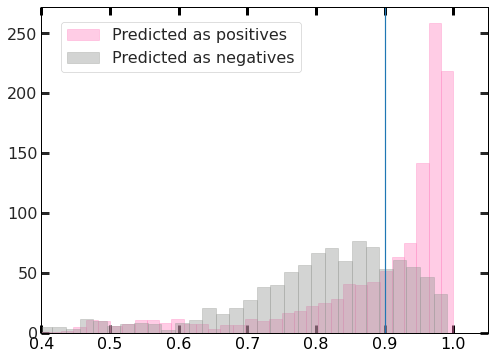

In [ ]:
import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = plt.figure(figsize=(8,6))
sns.set_style(style='white')
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
fig, ax = plt.subplots(figsize=(8,6))
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Tahoma']
#plt.rcParams["font.weight"] = "light"
#plt.rcParams["axes.labelweight"] = "normal"
#plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')


#b=sns.distplot(lab, hist=True, kde=True, 
 #            bins=50, color = '#95d0fc', 
  #           hist_kws={'edgecolor':'#5a7d9a'},
   #          kde_kws={'linewidth': 2,"alpha": 0.6,"shade": True,"color":'#95d0fc'},label='Known co-crystals')

b=sns.distplot(scores[labels.values.ravel()==1], hist=True, kde=False, #[val<11.5]
             bins=50, color = '#ff81c0', 
             hist_kws={'edgecolor':'#ff81c0'},
             kde_kws={'linewidth': 2,"alpha": 0.6,"shade": True, "color":'#ff028d'},label='Predicted as positives')
#
sns.distplot(scores[labels.values.ravel()==0], hist=True, kde=False, #[val>11.5]
             bins=50, color = '#929591', 
             hist_kws={'edgecolor':'#929591'},
             kde_kws={'linewidth': 2,"alpha": 0.6,"shade": True},label='Predicted as negatives')




#fig.legend(labels=['test_label1','test_label2'])
b.set_xlim(0.4, 1.05)
plt.legend(fontsize=16, bbox_to_anchor=(0.6,0.98))
plt.axvline(0.9)
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16})


(0.4, 1.0)

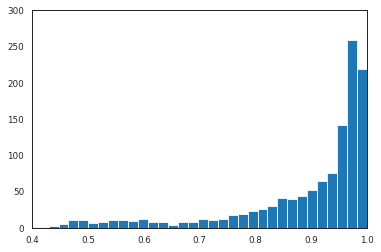

In [ ]:
plt.hist(scores[labels.values.ravel()==1],  bins=50)
plt.ylim(0,300)
plt.xlim(0.4,1)

(0.4, 1.0)

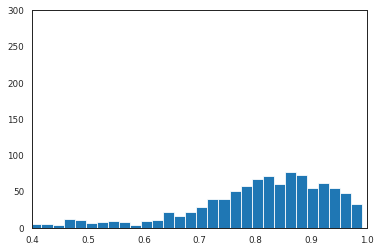

In [ ]:
plt.hist(scores[labels.values.ravel()==0], bins=50)
plt.ylim(0,300)
plt.xlim(0.4,1)

(array([ 2.,  0.,  1.,  2.,  8., 15.,  3., 11., 13.,  5.]),
 array([0.00175461, 0.09686218, 0.19196975, 0.28707731, 0.38218488,
        0.47729245, 0.57240002, 0.66750759, 0.76261516, 0.85772273,
        0.9528303 ]),
 <a list of 10 Patch objects>)

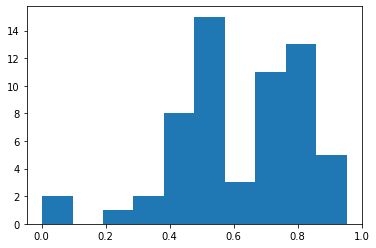

In [ ]:
plt.hist(scores[-60:])

(array([ 2.,  0.,  1.,  2.,  8., 15.,  3., 11., 13.,  5.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

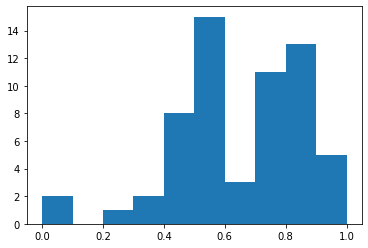

In [ ]:
plt.hist(scaler.fit_transform(scores[-60:].reshape(-1, 1)).ravel())

<Figure size 576x432 with 0 Axes>

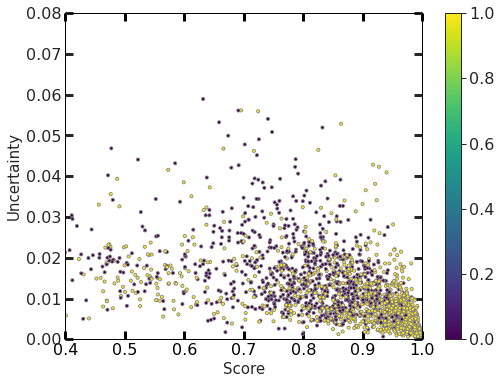

In [ ]:
from scipy.stats import gaussian_kde
import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = plt.figure(figsize=(8,6))
sns.set_style(style='white')
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
fig, ax = plt.subplots(figsize=(8,6))
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
x= scores#[-60:]
y=std
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
tza = ax.scatter(scaler.fit_transform(scores.reshape(-1, 1)).ravel(), std, c =labels , cmap='viridis' ,s=10, edgecolors='grey') #c=z,
plt.xlim(0.4,1)
plt.ylim(0,0.08)

ax.set_xlabel('Score', fontsize=15)
ax.set_ylabel('Uncertainty', fontsize=15)
plt.colorbar(tza)
#plt.savefig('/content/fingerprint_uncertainty.png', dpi=600)

In [ ]:
scores

array([0.95533359, 0.98002294, 0.99297277, ..., 0.70259261, 0.68096261,
       0.73814737])

In [ ]:
naki_mean, naki_std , spear, f1, mcc= ae_score_dropout(deep_SVDD, val_data_all.values, label_all)#.cpu().detach().numpy()
naki_mean

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


ValueError: ignored

In [ ]:
naki_std

In [ ]:
spear



In [ ]:
f1

In [ ]:
mcc

In [ ]:
np.corrcoef(-1*naki_mean, naki_std)#[0][1]

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


nan

In [ ]:

pub = -1*ae_score(deep_SVDD, praziquantel_df.iloc[:,:].values).cpu().detach().numpy()
pub1 = pub#X_scaler.transform(pub.reshape(-1,1))
pub_validation=pd.concat([pd.DataFrame(pub1, columns=['score']), pd.DataFrame(praziquantel_label.values[:], columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)

In [ ]:
#Evaluate on Map
ae_score,_ = ae_score_dropout(deep_SVDD, praziquantel_df.iloc[:,:].values)
roc_auc = roc_auc_score(praziquantel_label.values[:], ae_score)
print('Lmap', roc_auc)

TypeError: ignored

In [ ]:
np.mean(uncert, axis=0)#/100

2.571841

In [ ]:
#Evaluate on Map
ae_score,uncert = ae_score_dropout(deep_SVDD, lmap_df.iloc[:,:].values)
#roc_auc = roc_auc_score(lmap_label.values, ae_score)

#print('Lmap', roc_auc)
print(ae_score,uncert)

0.751604938271605 0.02020923926384238


In [ ]:
# Save the deepSVDD model
pth_path = ('/content/drive/MyDrive/checkpoints/model_250_1e-4_32_1e-04_fingerprint.pth') 
deep_SVDD.save_model(pth_path)
deep_SVDD.ae_net

PairsAutoEncoder(
  (encoder): PairsEncoder(
    (seq): Sequential(
      (0): SAB(
        (mab): MAB(
          (fc_q): Linear(in_features=4096, out_features=500, bias=True)
          (fc_k): Linear(in_features=4096, out_features=500, bias=True)
          (fc_v): Linear(in_features=4096, out_features=500, bias=True)
          (fc_o): Linear(in_features=500, out_features=500, bias=True)
        )
      )
      (1): SAB(
        (mab): MAB(
          (fc_q): Linear(in_features=500, out_features=50, bias=True)
          (fc_k): Linear(in_features=500, out_features=50, bias=True)
          (fc_v): Linear(in_features=500, out_features=50, bias=True)
          (fc_o): Linear(in_features=50, out_features=50, bias=True)
        )
      )
      (2): PMA(
        (mab): MAB(
          (fc_q): Linear(in_features=50, out_features=50, bias=True)
          (fc_k): Linear(in_features=50, out_features=50, bias=True)
          (fc_v): Linear(in_features=50, out_features=50, bias=True)
          (fc_o

In [ ]:
net_name='model_250_1e-4_32_1e-04_fingerprint.pth'
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'    
deep_SVDD.load_model('/content/drive/MyDrive/checkpoints/model_250_1e-4_32_1e-04_fingerprint.pth')#, True) 

NameError: ignored

In [ ]:
deep_SVDD.ae_net

PairsAutoEncoder(
  (encoder): PairsEncoder(
    (seq): Sequential(
      (0): SAB(
        (mab): MAB(
          (fc_q): Linear(in_features=4096, out_features=500, bias=True)
          (fc_k): Linear(in_features=4096, out_features=500, bias=True)
          (fc_v): Linear(in_features=4096, out_features=500, bias=True)
          (fc_o): Linear(in_features=500, out_features=500, bias=True)
        )
      )
      (1): SAB(
        (mab): MAB(
          (fc_q): Linear(in_features=500, out_features=50, bias=True)
          (fc_k): Linear(in_features=500, out_features=50, bias=True)
          (fc_v): Linear(in_features=500, out_features=50, bias=True)
          (fc_o): Linear(in_features=50, out_features=50, bias=True)
        )
      )
      (2): PMA(
        (mab): MAB(
          (fc_q): Linear(in_features=50, out_features=50, bias=True)
          (fc_k): Linear(in_features=50, out_features=50, bias=True)
          (fc_v): Linear(in_features=50, out_features=50, bias=True)
          (fc_o

In [ ]:
# Scaffold splitter

cocrystals.loc[df_paws.index]

train_df=pd.concat([pd.DataFrame(cocrystals.loc[df_paws.index].values,columns=cocrystals.columns.values), pd.DataFrame(df_paws.values, columns=df_paws.columns.values)], axis=1)
train_df.tail()

csd_id  ... paws_2_4095
7104  WUNFET  ...           0
7105  WUNFUJ  ...           0
7106  WUNGEU  ...           0
7107  WUNHAR  ...           0
7108  WUZLEL  ...           0

[5 rows x 8199 columns]

In [ ]:
import deepchem as dc

train_df=pd.concat([pd.DataFrame(cocrystals.loc[df_paws.index].values,columns=cocrystals.columns.values), pd.DataFrame(df_paws.values, columns=df_paws.columns.values)], axis=1)
mols = train_df.smiles1.values
#print("Original set of molecules")
#print(mols)

dataset_cocry = dc.data.NumpyDataset(X=mols, ids=mols)

lab_list=[]
unlab_list=[]
test_list=[]
auc=[]
scores=[]

splitter = dc.splits.RandomStratifiedSplitter() #ScaffoldSplitter()# 
splits = splitter.k_fold_split(dataset_cocry, seed=1, k=20)
train_splits = [s[0] for s in splits]

  #train_valid_test_split(dataset_cocry, seed=i)
  #print(train)#.ids)
  #print(np.array(train_df)[train.index]) #train_data = np.array(X_train_val)[train]
for k,i in enumerate(train_splits):
  print(i.X)#train_splits[i])
  X_train = train_df[train_df.smiles1.isin(i.X)].iloc[:, 7:]
  print(X_train)
  dataset = Pairs_Dataset('', data= X_train )
  torch.manual_seed(0)                     
  deep_SVDD.pretrain(dataset, optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-4,
                   n_epochs = 200 , #100,
                   lr_milestones=(100,),
                   batch_size=32, 
                   weight_decay=0.005,  #0.005
                   device=device,
                   n_jobs_dataloader=0)  
  pth_path = ('/content/drive/MyDrive/checkpoints/model_checkpoint_%i.pth'%k) 
  deep_SVDD.save_model(pth_path)
  auc.append(deep_SVDD.ae_trainer.test(dataset, deep_SVDD.ae_net))
  scores.append(ae_score(deep_SVDD, df_all.values).cpu().detach().numpy())

INFO:deepchem.splits.splitters:Computing K-fold split
INFO:deepchem.data.datasets:TIMING: dataset construction took 0.006 s
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Constructing selection output shard 1
INFO:deepchem.data.datasets:Selecting from input shard 1/1 for selection output shard 1
INFO:deepchem.data.datasets:TIMING: dataset construction took 0.014 s
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Constructing selection output shard 1
INFO:deepchem.data.datasets:Selecting from input shard 1/1 for selection output shard 1
INFO:deepchem.data.datasets:TIMING: dataset construction took 0.059 s
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Merging in dataset 0/1
INFO:deepchem.data.datasets:TIMING: dataset construction took 0.014 s
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Merging in dataset 0/1
INFO:deepchem.data.datasets:TIMING: 

['Nc1ccc(I)cc1' 'ClC1=C(Cl)C(=O)C(=C(Cl)C1=O)Cl' 'CN1C=Nc2c(N)ncnc12' ...
 'Fc1c(F)c(I)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(I)c(F)c(F)c(F)c1I'
 'Fc1c(F)c(F)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(F)c(F)c(F)c(F)c1I'
 'CCOc1cc(ccc1OC)C(CS(C)(=O)=O)N1C(=O)c2cccc(NC(C)=O)c2C1=O']
      paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
1            0         0         0  ...            0            0            0
2            0         0         0  ...            0            0            0
3            0         0         0  ...            0            0            0
4            0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
7104         0         0         0  ...            0            0            0
7105         0         0         0  ...            0            0            0
7106         0       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/200	 Time: 6.573	 Loss: 28.86437060
INFO:root:  Epoch 2/200	 Time: 6.570	 Loss: 22.19869625
INFO:root:  Epoch 3/200	 Time: 6.543	 Loss: 19.36036438
INFO:root:

['N#CC(C#N)=C1C=CC(C=C1)=C(C#N)C#N' 'O1c2ccccc2Oc2ccccc12'
 'O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O' ...
 'Fc1c(F)c(I)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(I)c(F)c(F)c(F)c1I'
 'Fc1c(F)c(F)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(F)c(F)c(F)c(F)c1I'
 'CCOc1cc(ccc1OC)C(CS(C)(=O)=O)N1C(=O)c2cccc(NC(C)=O)c2C1=O']
      paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
1            0         0         0  ...            0            0            0
2            0         0         0  ...            0            0            0
3            0         0         0  ...            0            0            0
4            0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
7104         0         0         0  ...            0            0            0
7105         0         0         0  ...            0            0         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/200	 Time: 6.215	 Loss: 28.72535569
INFO:root:  Epoch 2/200	 Time: 6.394	 Loss: 22.01026006
INFO:root:  Epoch 3/200	 Time: 6.186	 Loss: 19.21603726
INFO:root:

['N#CC(C#N)=C1C=CC(C=C1)=C(C#N)C#N' 'O1c2ccccc2Oc2ccccc12'
 'O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O' ...
 'Fc1c(F)c(I)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(I)c(F)c(F)c(F)c1I'
 'Fc1c(F)c(F)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(F)c(F)c(F)c(F)c1I'
 'CCOc1cc(ccc1OC)C(CS(C)(=O)=O)N1C(=O)c2cccc(NC(C)=O)c2C1=O']
      paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
1            0         0         0  ...            0            0            0
2            0         0         0  ...            0            0            0
3            0         0         0  ...            0            0            0
4            0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
7104         0         0         0  ...            0            0            0
7105         0         0         0  ...            0            0         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/200	 Time: 6.563	 Loss: 28.65933170
INFO:root:  Epoch 2/200	 Time: 6.829	 Loss: 22.06451625
INFO:root:  Epoch 3/200	 Time: 6.584	 Loss: 19.26907384
INFO:root:

['N#CC(C#N)=C1C=CC(C=C1)=C(C#N)C#N' 'O1c2ccccc2Oc2ccccc12'
 'O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O' ...
 'Fc1c(F)c(I)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(I)c(F)c(F)c(F)c1I'
 'Fc1c(F)c(F)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(F)c(F)c(F)c(F)c1I'
 'CCOc1cc(ccc1OC)C(CS(C)(=O)=O)N1C(=O)c2cccc(NC(C)=O)c2C1=O']
      paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
1            0         0         0  ...            0            0            0
2            0         0         0  ...            0            0            0
3            0         0         0  ...            0            0            0
4            0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
7104         0         0         0  ...            0            0            0
7105         0         0         0  ...            0            0         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/200	 Time: 6.241	 Loss: 28.76300677
INFO:root:  Epoch 2/200	 Time: 6.435	 Loss: 22.07417498
INFO:root:  Epoch 3/200	 Time: 6.248	 Loss: 19.28963316
INFO:root:

['N#CC(C#N)=C1C=CC(C=C1)=C(C#N)C#N' 'O1c2ccccc2Oc2ccccc12'
 'O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O' ...
 'Fc1c(F)c(I)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(I)c(F)c(F)c(F)c1I'
 'Fc1c(F)c(F)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(F)c(F)c(F)c(F)c1I'
 'CCOc1cc(ccc1OC)C(CS(C)(=O)=O)N1C(=O)c2cccc(NC(C)=O)c2C1=O']
      paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
1            0         0         0  ...            0            0            0
2            0         0         0  ...            0            0            0
3            0         0         0  ...            0            0            0
4            0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
7103         0         0         0  ...            0            0            0
7105         0         0         0  ...            0            0         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/200	 Time: 6.540	 Loss: 28.73811921
INFO:root:  Epoch 2/200	 Time: 6.725	 Loss: 22.13312409
INFO:root:  Epoch 3/200	 Time: 6.509	 Loss: 19.31659459
INFO:root:

['N#CC(C#N)=C1C=CC(C=C1)=C(C#N)C#N' 'O1c2ccccc2Oc2ccccc12'
 'O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O' ...
 'Fc1c(F)c(I)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(I)c(F)c(F)c(F)c1I'
 'Fc1c(F)c(F)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(F)c(F)c(F)c(F)c1I'
 'CCOc1cc(ccc1OC)C(CS(C)(=O)=O)N1C(=O)c2cccc(NC(C)=O)c2C1=O']
      paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
1            0         0         0  ...            0            0            0
2            0         0         0  ...            0            0            0
3            0         0         0  ...            0            0            0
4            0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
7104         0         0         0  ...            0            0            0
7105         0         0         0  ...            0            0         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/200	 Time: 6.233	 Loss: 28.78117895
INFO:root:  Epoch 2/200	 Time: 6.433	 Loss: 22.11074611
INFO:root:  Epoch 3/200	 Time: 6.215	 Loss: 19.24141787
INFO:root:

['N#CC(C#N)=C1C=CC(C=C1)=C(C#N)C#N' 'O1c2ccccc2Oc2ccccc12'
 'O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O' ...
 'Fc1c(F)c(I)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(I)c(F)c(F)c(F)c1I'
 'Fc1c(F)c(F)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(F)c(F)c(F)c(F)c1I'
 'CCOc1cc(ccc1OC)C(CS(C)(=O)=O)N1C(=O)c2cccc(NC(C)=O)c2C1=O']
      paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
1            0         0         0  ...            0            0            0
2            0         0         0  ...            0            0            0
3            0         0         0  ...            0            0            0
4            0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
7104         0         0         0  ...            0            0            0
7105         0         0         0  ...            0            0         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/200	 Time: 6.348	 Loss: 28.74493307
INFO:root:  Epoch 2/200	 Time: 6.529	 Loss: 22.09287177
INFO:root:  Epoch 3/200	 Time: 6.337	 Loss: 19.28679985
INFO:root:

['N#CC(C#N)=C1C=CC(C=C1)=C(C#N)C#N' 'O1c2ccccc2Oc2ccccc12'
 'O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O' ...
 'Fc1c(F)c(I)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(I)c(F)c(F)c(F)c1I'
 'Fc1c(F)c(F)c(c(I)c1F)c1c(F)c(F)c(c(F)c1F)c1c(F)c(F)c(F)c(F)c1I'
 'CCOc1cc(ccc1OC)C(CS(C)(=O)=O)N1C(=O)c2cccc(NC(C)=O)c2C1=O']
      paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0            0         0         0  ...            0            0            0
1            0         0         0  ...            0            0            0
2            0         0         0  ...            0            0            0
3            0         0         0  ...            0            0            0
4            0         0         0  ...            0            0            0
...        ...       ...       ...  ...          ...          ...          ...
7104         0         0         0  ...            0            0            0
7105         0         0         0  ...            0            0         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/200	 Time: 6.264	 Loss: 28.75672996
INFO:root:  Epoch 2/200	 Time: 6.528	 Loss: 22.16699931
INFO:root:  Epoch 3/200	 Time: 6.237	 Loss: 19.35219866
INFO:root:

In [ ]:
from sklearn.model_selection import train_test_split
lab_list=[]
unlab_list=[]
test_list=[]
auc=[]
scores=[]
for i in range(10):
  X_train, X_test= train_test_split( df_paws.iloc[:, :],  test_size=0.15, random_state=i)
  dataset = Pairs_Dataset('', data= X_train )
  torch.manual_seed(0)                     
  deep_SVDD.pretrain(dataset, optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-4,
                   n_epochs = 50 , #100,
                   lr_milestones=cfg.settings['lr_milestone'],
                   batch_size=32, 
                   weight_decay=0.005,  #0.005
                   device=device,
                   n_jobs_dataloader=0)  
  auc.append(deep_SVDD.ae_trainer.test(dataset, deep_SVDD.ae_net))
  scores.append(ae_score(deep_SVDD, val_data_all.values).cpu().detach().numpy())
  #pth_path = ('/content/drive/MyDrive/checkpoints/model_checkpoint_%i.pth'%i) 
  #deep_SVDD.save_model(pth_path)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/50	 Time: 5.438	 Loss: 29.45954101
INFO:root:  Epoch 2/50	 Time: 5.403	 Loss: 22.94477587
INFO:root:  Epoch 3/50	 Time: 5.417	 Loss: 20.12686506
INFO:root:  E

In [ ]:
folds=pd.concat([ validation_data ,pd.DataFrame(np.transpose(scores), columns = ['scores_%s'%i for i in range(5)])],axis=1)
#.to_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/validation_data/10folds.csv')

In [ ]:
folds = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/validation_data/10folds.csv')
folds

Unnamed: 0  Co-crystal Dataset  ...   scores_7   scores_8   scores_9
0              0           1   grecu  ...   3.304495   3.098884   2.928476
1              1           1   grecu  ...   1.505149   1.364242   1.373077
2              2           1   grecu  ...   2.570243   0.829680   1.411519
3              3           1   grecu  ...   1.277753   1.425576   1.185919
4              4           1   grecu  ...   1.351371   1.118362   1.329633
...          ...         ...     ...  ...        ...        ...        ...
2279        2279           0    pahs  ...  23.650082  26.009356  23.751892
2280        2280           0    pahs  ...  20.581318  19.813984  23.759193
2281        2281           0    pahs  ...  17.278057  19.650509  20.339226
2282        2282           1    pahs  ...   5.001029   5.285284   4.821526
2283        2283           1    pahs  ...   3.635153   4.229101   3.627887

[2284 rows x 16 columns]

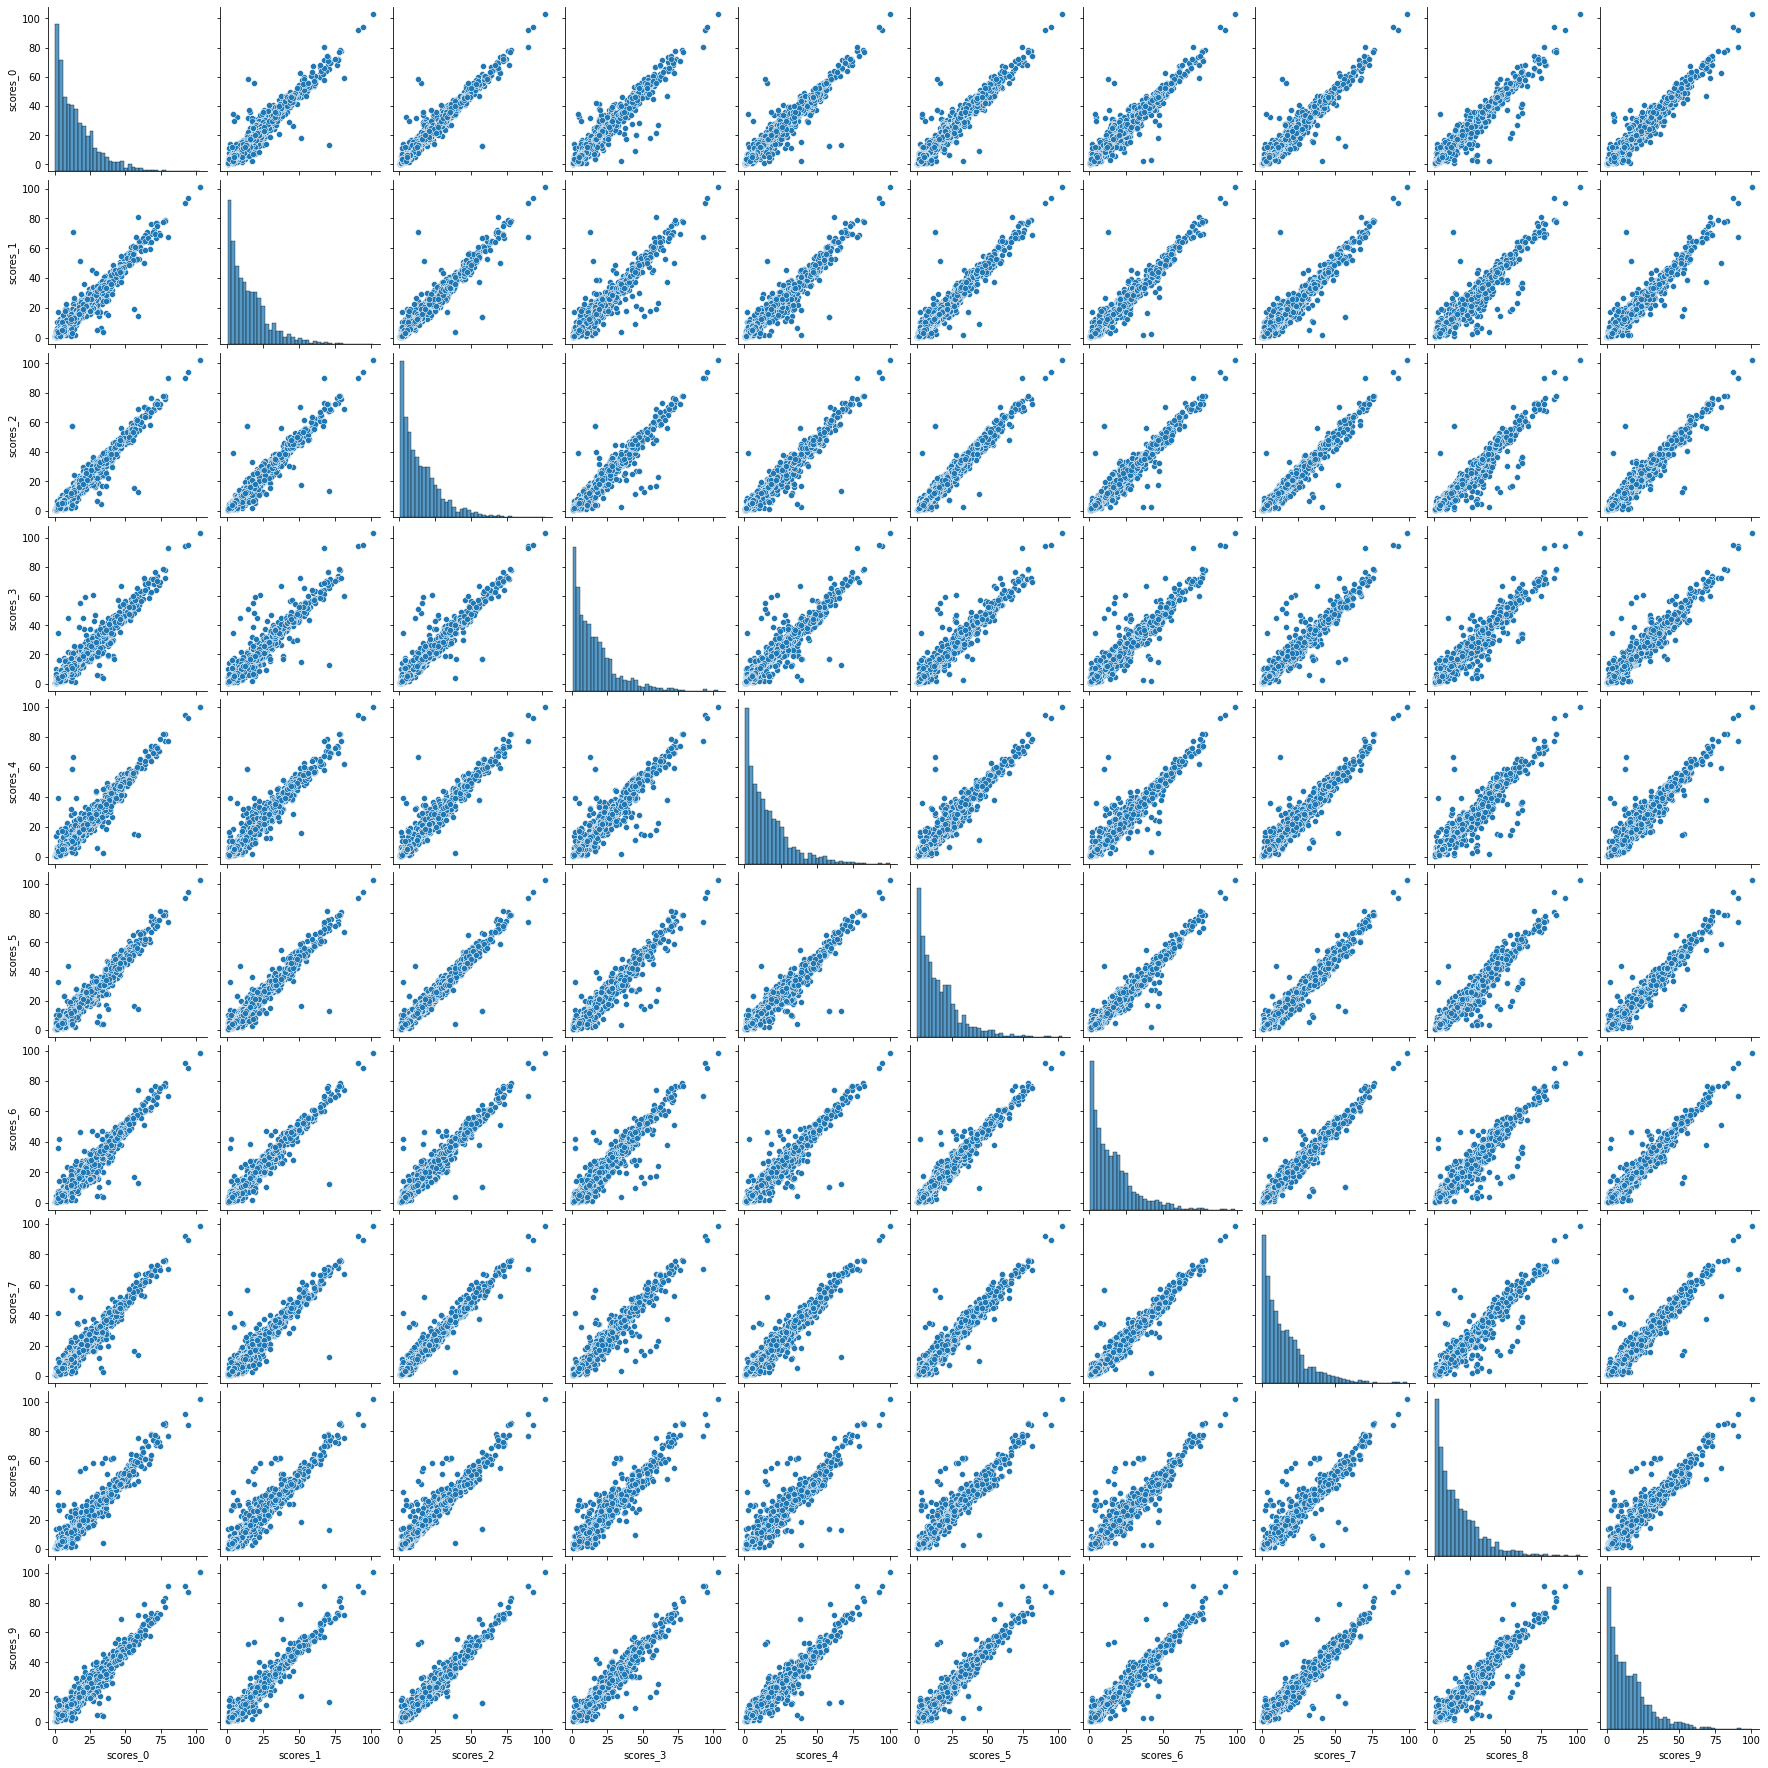

In [ ]:
# Seaborn visualization library
import seaborn as sns
# Create the default pairplot
sns.pairplot(folds.iloc[:,6:])

In [ ]:
np.mean([folds[f'scores_{i}'] for i in range(0,7)],axis=0)
# np.mean([folds[f'scores_{i}'] for i in range(0,1)],axis=0)

roc_auc_score(folds['Co-crystal'].values[:], folds.scores_5[:]*-1)

0.5169404628940184

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler()
lab = ae_score(deep_SVDD, df_paws.iloc[:,:].values).cpu().detach().numpy() #-1*
val = ae_score(deep_SVDD, val_data_all).cpu().detach().numpy() #-1*
lab1 = X_scaler.fit_transform(lab.reshape(-1,1))
labeled = pd.DataFrame(lab1, columns=['score'])#.describe()
lab = X_scaler.fit_transform((-1*lab[lab<80]).reshape(-1,1))
val = X_scaler.transform((-1*val[val<80]).reshape(-1,1))
pd.DataFrame(lab, columns=['score']).describe()

NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<Figure size 576x432 with 0 Axes>

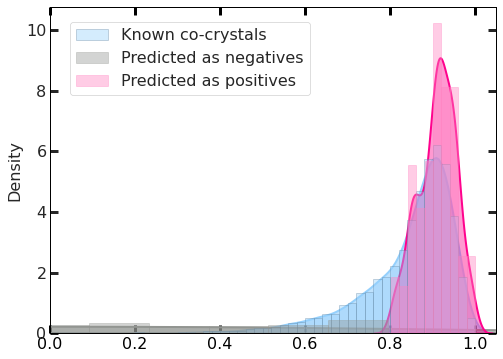

In [ ]:
import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})
fig = plt.figure(figsize=(8,6))
sns.set_style(style='white')
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
fig, ax = plt.subplots(figsize=(8,6))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')


#sns.distplot(folds["scores_0"], hist=True, kde=True, 
 #            bins=int(180/5), color = 'darkblue', 
  #           hist_kws={'edgecolor':'black'},
 #            kde_kws={'linewidth': 2})
#
#sns.distplot(folds["scores_1"], hist=True, kde=True, 
 #            bins=int(180/5), color = 'red', 
  #           hist_kws={'edgecolor':'black'},
   #          kde_kws={'linewidth': 2})

#sns.distplot(folds["scores_2"], hist=True, kde=True, 
 #            bins=int(180/5), color = 'yellow', 
  #           hist_kws={'edgecolor':'black'},
   #          kde_kws={'linewidth': 2})

b=sns.distplot(lab, hist=True, kde=True, 
             bins=50, color = '#95d0fc', 
             hist_kws={'edgecolor':'#5a7d9a'},
             kde_kws={'linewidth': 2,"alpha": 0.6,"shade": True,"color":'#95d0fc'},label='Known co-crystals')

sns.distplot(val[val<0.8], hist=True, kde=True, #[val>11.5]
             bins=100, color = '#929591', 
             hist_kws={'edgecolor':'#929591'},
             kde_kws={'linewidth': 2,"alpha": 0.6,"shade": True},label='Predicted as negatives')

sns.distplot(val[val>0.8], hist=True, kde=True, #[val<11.5]
             bins=10, color = '#ff81c0', 
             hist_kws={'edgecolor':'#ff81c0'},
             kde_kws={'linewidth': 2,"alpha": 0.4,"shade": True, "color":'#ff028d'},label='Predicted as positives')
#


#fig.legend(labels=['test_label1','test_label2'])
b.set_xlim(0, 1.05)
plt.legend(fontsize=16, bbox_to_anchor=(0.6,0.98))
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16})

#plt.savefig('/content/fingerprint_distr.png', dpi=600)

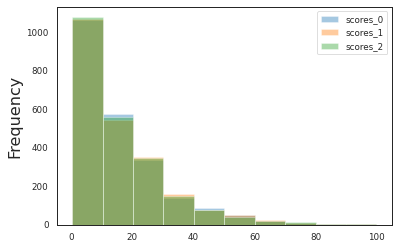

In [ ]:
#plt.hist(folds.scores_0, density=True)

folds[["scores_0", "scores_1","scores_2"]].plot.hist(alpha=0.4)

In [ ]:
A = scores[0]
B = scores[1]
#print() "difference:", A - B)
print ("SAD:", np.sum(np.abs(A - B)))
print ("SSD:", np.sum(np.square(A - B)))
print("correlation:", np.corrcoef(np.array(([scores[i] for i in range(5) ])))[0, 1])

SAD: 3129.002
SSD: 18633.656
correlation: 0.9805805195033149


In [ ]:
import glob
def get_average_model(dir_path):
  files = glob.glob(f'{dir_path}/*.pth')
  R, c, avg_net, avg_ae = [], [], None, None
  for i, model_file in enumerate(files):
    m = torch.load(model_file)
    R.append(m['R'])
    #c.append(m['c'])
    net, ae = m['net_dict'], m['ae_net_dict']
    if i == 0:
      avg_net, avg_ae = net, ae
    else:
      for (k, v) in avg_net.items():
        avg_net[k].mul_(i).add_(net[k]).div_(i + 1)
      for (k, v) in avg_ae.items():
        avg_ae[k].mul_(i).add_(ae[k]).div_(i + 1)

  avg_R = np.mean(R)
  avg_c = np.mean(c, 0).tolist()
  fname = f'{dir_path}/avg_checkpoint.pth'
  torch.save({'R': avg_R, 'c': avg_c,  'net_dict': avg_net, 'ae_net_dict': avg_ae}, fname) #'c': avg_c,
  return fname

get_average_model('/content/drive/MyDrive/checkpoints')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


'/content/drive/MyDrive/checkpoints/avg_checkpoint.pth'

In [ ]:
deep_SVDD.load_model('/content/drive/MyDrive/checkpoints/model_checkpoint_2.pth', True)
#deep_SVDD.ae_trainer.test(dataset, deep_SVDD.ae_net)

In [ ]:
auc = deep_SVDD.ae_trainer.test(dataset, deep_SVDD.ae_net)

AttributeError: ignored

In [ ]:
from optim.ae_trainer import bidirectional_score

In [ ]:
def ae_score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.ae_net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        #print(y.dim(), y.shape, X.shape)
        scores = bidirectional_score(X, y)#torch.sum((y - X) ** 2, dim=tuple(range(1, y.dim())))
    return scores

In [ ]:

def score(deep_SVDD, X):
    with torch.no_grad():
        device = 'cpu'  
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [ ]:
 deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-4,
                n_epochs = 20,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=0)  

INFO:root:Initializing center c...
INFO:root:Center c initialized.
INFO:root:Starting training...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/20	 Time: 1.813	 Loss: 0.02056791
INFO:root:  Epoch 2/20	 Time: 1.796	 Loss: 0.00278866
INFO:root:  Epoch 3/20	 Time: 1.806	 Loss: 0.00138962
INFO:root:  Epoch 4/20	 Time: 1.812	 Loss: 0.00102257
INFO:root:  Epoch 5/20	 Time: 1.812	 Loss: 0.00087521
INFO:root:  Epoch 6/20	 Time: 1.812	 Loss: 0.00074984
INFO:root:  Epoch 7/20	 Tim

In [ ]:
# Evaluate on the RC data
roc_auc = roc_auc_score(rc_label.values, -1*ae_score(deep_SVDD, rc_df.iloc[:,2:].values).cpu().detach().numpy())
print('RC', roc_auc)

# Evaluate on the Grecu data
roc_auc = roc_auc_score(label.values, -1*ae_score(deep_SVDD, grecu_df.iloc[:,2:].values).cpu().detach().numpy())
print('Grecu', roc_auc)

# Evaluate on the pranzicatel
roc_auc = roc_auc_score( praziquantel_label.values, -1*ae_score(deep_SVDD, praziquantel_df.iloc[:,:].values).cpu().detach().numpy())
print('pranzicatel', roc_auc)

RC 0.7579566753171857
Grecu 0.7644485378770434
pranzicatel 0.37962962962962965


In [ ]:
# Public data validation

pub = -1*ae_score(deep_SVDD, praziquantel_df.iloc[:,:].values).cpu().detach().numpy()
pub1 = pub#X_scaler.transform(pub.reshape(-1,1))
pub_validation=pd.concat([pd.DataFrame(pub1, columns=['score']), pd.DataFrame(praziquantel_label.values[:], columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)

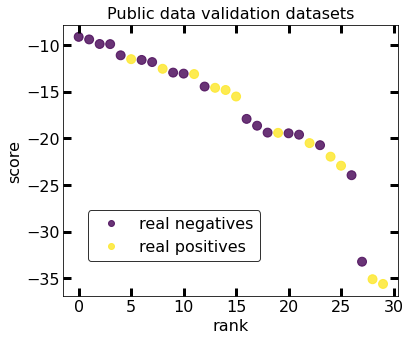

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(6,5))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('score', fontsize=16)
plt.xlabel('rank', fontsize=16)


x=np.arange(len(pub))
scatter=plt.scatter(x ,pub_val_sort.score, c=pub_val_sort.color, s=80, alpha=0.8)
#plt.ylim(-0.01, 1.04)
plt.title('Public data validation datasets', fontsize=16)
legend=plt.legend(handles=scatter.legend_elements()[0], labels=['real negatives', 'real positives'], loc='lower left', fontsize=16, bbox_to_anchor=(0.05, 0.1, 0.6, 1.8))
legend.get_frame().set_edgecolor('black')
#plt.title('Public data validation datasets')
#plt.savefig('/content/colorplot.png', bbox_inches='tight' ,dpi=600)

In [ ]:
#Evaluate on Map
roc_auc = roc_auc_score(lmap_label.values, -1*ae_score(deep_SVDD, lmap_df.iloc[:,:].values).cpu().detach().numpy())
print('Lmap', roc_auc)

Lmap 0.8833333333333333


In [ ]:
#Evaluate on Map
roc_auc = roc_auc_score(lmap_label.values, -1*ae_score(deep_SVDD, lmap_df.iloc[:,:].values).cpu().detach().numpy())
print('Lmap', roc_auc)

Lmap 0.8802469135802469


In [ ]:
#Evaluate on phenolic_acid
roc_auc = roc_auc_score(phenolic_acids_label.values, -1*ae_score(deep_SVDD, phen_acid_df.iloc[:,:].values).cpu().detach().numpy())
print('Phen_acids', roc_auc)

Phen_acids 0.7048440065681445


In [ ]:
# Evaluate on the RC data
roc_auc = roc_auc_score(rc_label.values, -1*ae_score(deep_SVDD, rc_df.iloc[:,2:].values).cpu().detach().numpy())
print('RC', roc_auc)

# Evaluate on the Grecu data
roc_auc = roc_auc_score(label.values, -1*ae_score(deep_SVDD, grecu_df.iloc[:,2:].values).cpu().detach().numpy())
print('Grecu', roc_auc)

#Evaluate on Map
roc_auc = roc_auc_score(lmap_label.values, -1*ae_score(deep_SVDD, lmap_df.iloc[:,:].values).cpu().detach().numpy())
print('Lmap', roc_auc)

#Evaluate on phenolic_acid
roc_auc = roc_auc_score(phenolic_acids_label.values, -1*ae_score(deep_SVDD, phen_acid_df.iloc[:,:].values).cpu().detach().numpy())
print('Phen_acids', roc_auc)

#Evaluate on phenolic_acid
roc_auc = roc_auc_score(dicarboxylic_acids_label.values, -1*ae_score(deep_SVDD, dicarboxylic_acid_df.iloc[:,:].values).cpu().detach().numpy())
print('Dicarboxyl_acids', roc_auc)

# Evaluate pahs
roc_auc = roc_auc_score(pahs_label.values, -1*ae_score(deep_SVDD, pahs_df.iloc[:,:].values).cpu().detach().numpy())
print('pahs', roc_auc)

# Evaluate akeroy data
roc_auc = roc_auc_score(akeroy_label.values, -1*ae_score(deep_SVDD, akeroy_df.iloc[:,2:].values).cpu().detach().numpy())
print('akeroy', roc_auc)


RC 0.7515318627450981
Grecu 0.7673651086038836
Lmap 0.845679012345679
Phen_acids 0.7089490968801313
Dicarboxyl_acids 0.6551745951417004
pahs 0.875
akeroy 0.7565610859728507


In [ ]:
# Desloratadine
roc_auc = roc_auc_score(akeroy_label_des.values, -1*ae_score(deep_SVDD, akeroy_df.iloc[:41,2:].values).cpu().detach().numpy())
print('akeroy_deslor', roc_auc)


#Loratadine
roc_auc = roc_auc_score(akeroy_label_lo.values, -1*ae_score(deep_SVDD, akeroy_df.iloc[41:,2:].values).cpu().detach().numpy())
print('akeroy_lor', roc_auc)


akeroy_deslor 0.6428571428571429
akeroy_lor 0.8354838709677419


In [ ]:
# Evaluate 
label_all = np.concatenate([rc_label.values, label.values, lmap_label.values, phenolic_acids_label,dicarboxylic_acids_label.values,artem_label.values,akeroy_label.values, pahs_label.values ])
val_data_all = np.concatenate([rc_df.iloc[:,2:].values , grecu_df.iloc[:,2:].values, lmap_df.iloc[:,:].values,phen_acid_df.iloc[:,:].values,dicarboxylic_acid_df.iloc[:,:].values,
                               artem_df.iloc[:,:].values, akeroy_df.iloc[:,2:].values, pahs_df.iloc[:,:].values])

roc_auc = roc_auc_score(labels.values, -1*ae_score(deep_SVDD, df_all.values).cpu().detach().numpy())
print('All', roc_auc)

All 0.7318231766745932


In [ ]:
label_all = np.concatenate([rc_label.values, label.values, lmap_label.values, phenolic_acids_label,dicarboxylic_acids_label.values,artem_label.values,akeroy_label.values ]) #, pahs_label.values
val_data_all = np.concatenate([rc_df.iloc[:,2:].values , grecu_df.iloc[:,2:].values, lmap_df.iloc[:,:].values,phen_acid_df.iloc[:,:].values,dicarboxylic_acid_df.iloc[:,:].values,
                               artem_df.iloc[:,:].values, akeroy_df.iloc[:,2:].values]) #,pahs_df.iloc[:,:].values
df_all = pd.DataFrame(val_data_all).drop_duplicates()
labels= pd.DataFrame(label_all).loc[df_all.index]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()

In [ ]:
# Public data validation

pub = -1*ae_score(deep_SVDD, val_data_all).cpu().detach().numpy() 
pub=pd.DataFrame(pub, columns=['score'])
#pub= pub[pub.score>-80]
pub1 = pub.values #X_scaler.fit_transform(pub.values.reshape(-1,1))
pub_validation=pd.concat([pd.DataFrame(pub1, columns=['score']), pd.DataFrame(label_all[pub.index], columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)
pub_val_sort

score  color
73   -2.610104e-09      1
1433 -6.587249e-09      1
1315 -6.983443e-09      1
4    -7.047902e-09      1
85   -1.090087e-08      1
...            ...    ...
892  -7.797066e+01      0
2263 -8.006857e+01      1
2270 -8.538670e+01      0
2207 -8.948668e+01      1
2248 -9.129269e+01      0

[2278 rows x 2 columns]

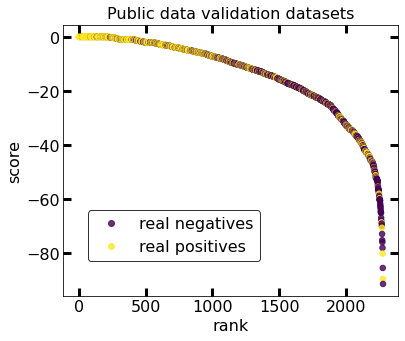

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(6,5))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('score', fontsize=16)
plt.xlabel('rank', fontsize=16)


x=np.arange(len(pub))
scatter=plt.scatter(x ,pub_val_sort.score, c=pub_val_sort.color, s=30, alpha=0.8)
#plt.ylim(0.0, 1.04)
plt.title('Public data validation datasets', fontsize=16)
legend=plt.legend(handles=scatter.legend_elements()[0], labels=['real negatives', 'real positives'], loc='lower left', fontsize=16, bbox_to_anchor=(0.05, 0.1, 0.6, 1.8))
legend.get_frame().set_edgecolor('black')
#plt.title('Public data validation datasets')
#plt.savefig('/content/colorplot.png', bbox_inches='tight' ,dpi=600)

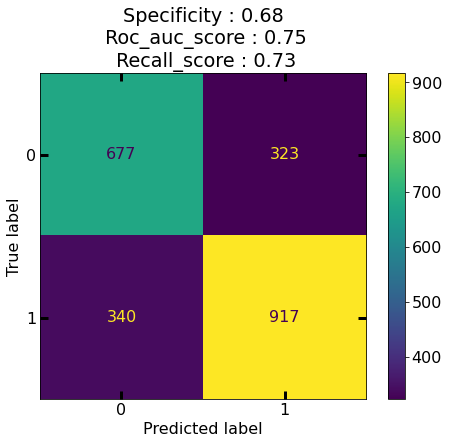

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,6))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
plt.rcParams.update({'font.size': 16})
ax.set_xlabel({'size':'18'} )
ax.set_ylabel({'size':'18'} )
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# Public available
y_pred  =[1 if i>=-13 else 0 for i in pub_validation.score.values]
y_test = pub_validation.color.values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
#roc_auc = roc_auc_score(y_test, predicted_scores)
recall=recall_score(y_test, y_pred)
#print('Specificity : ', round(specificity,2))
#print('Roc_auc_score : ', roc_auc)
#print('Recall_score : ', round(recall,2))
ax.set_title('Specificity : ' + str(round(specificity,2)) +
             '\n Roc_auc_score : '+ str(round(roc_auc,2)) +
             '\n Recall_score : ' +  str(round(recall,2)) )


cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=(0,1)).plot(ax=ax, values_format='.0f')
#plt.savefig('/content/confusion.png', bbox_inches='tight' ,dpi=600)

In [ ]:
X_scaler = MinMaxScaler()
lab = -1*ae_score(deep_SVDD, df_paws.iloc[:,:].values).cpu().detach().numpy() #
lab1 = X_scaler.fit_transform(lab.reshape(-1,1))
pd.DataFrame(lab).describe()

NameError: ignored

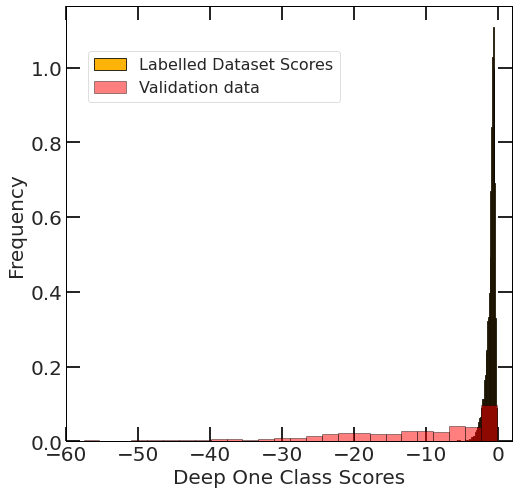

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

_, bins , _ = plt.hist(lab, bins=50, ec='k', histtype='bar', density=True, alpha=1, color='#feb308', label='Labelled Dataset Scores')
#_= plt.hist(validation.score, bins=150,density=True, ec='k',alpha=0.5, color='red', label='Paracetamol Validation Scores')
_= plt.hist(pub.values, bins=50,density=True, ec='k',alpha=0.5, color='red', label='Validation data')
#_= plt.hist(unlab_final_drug.test_score, bins=bins,density=True, ec='k',alpha=0.5, color='#0165fc', label='Drug Subset Scores')
#_= plt.hist(val.train_score, bins=bins,density=True, ec='k',alpha=0.5, color='red', label='Unlabelled Dataset Scores')
#_ = plt.axvline(x=0.85, label='Threshold', c='r', linewidth=4)

plt.grid(False)
plt.xlim(-60, 2)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")

plt.legend(prop={'size': 16}, loc=[0.05, 0.78])
#plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/fingerprint_scores_histogram.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

In [ ]:
# Public data validation

pub = -1*ae_score(deep_SVDD, dicarboxylic_all.iloc[:,2:].values).cpu().detach().numpy()
pub1 =  X_scaler.fit_transform(pub.reshape(-1,1))
pub_validation=pd.concat([pd.DataFrame(dicarboxylic_all.iloc[:,:2].values, columns = ['name1', 'namee2']),pd.DataFrame(pub1, columns=['score']), pd.DataFrame(dicarboxylic_acids_label.values, columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)

NameError: ignored

In [ ]:
pub_validation[pub_validation.score.values < 0.5]

score  color
658   0.493706      0
664   0.452946      0
665   0.406208      0
666   0.498115      0
669   0.385518      0
...        ...    ...
2107  0.454716      1
2109  0.469796      0
2110  0.079588      0
2113  0.490551      1
2117  0.285057      0

[81 rows x 2 columns]

Text(0.5, 1.0, 'Public data validation set')

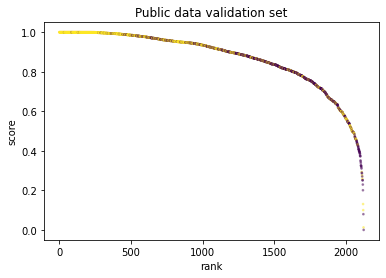

In [ ]:
x=np.arange(len(pub))
plt.scatter(x ,pub_val_sort.score, c=pub_val_sort.color, s=3, alpha=0.4)
#plt.ylim(-100,0)
#plt.axhline(y=0.9, label='Threshold', c='r', linewidth=4)
plt.ylabel('score')
plt.xlabel('rank')
plt.title('Public data validation set')


0.7409688013136289


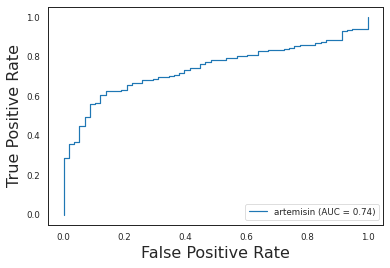

In [ ]:
roc_auc = roc_auc_score(phenolic_acids_label, -1*ae_score(deep_SVDD, phen_acid_df.iloc[:,:].values).cpu().detach().numpy())

print(roc_auc)
fpr, tpr, _ = roc_curve(phenolic_acids_label, -1*ae_score(deep_SVDD, phen_acid_df.iloc[:,:].values).cpu().detach().numpy())
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='artemisin').plot()

In [ ]:
# Public data validation

pub = -1*ae_score(deep_SVDD, rc_df.iloc[:,2:].values).cpu().detach().numpy()
pub1 =  X_scaler.fit_transform(pub.reshape(-1,1))
pub_validation=pd.concat([pd.DataFrame(pub1, columns=['score']), pd.DataFrame(rc_label.values, columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)
pub_val_sort.shape

(680, 2)

In [ ]:
#rc_scores = pd.concat([rc_df.iloc[:,:2], pub_validation], axis=1)
#rc_scores.to_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/PublicallyAvalibleData/RC_validation_set/rc_scores_fingerprint.csv')

Text(0.5, 1.0, 'RC data validation set')

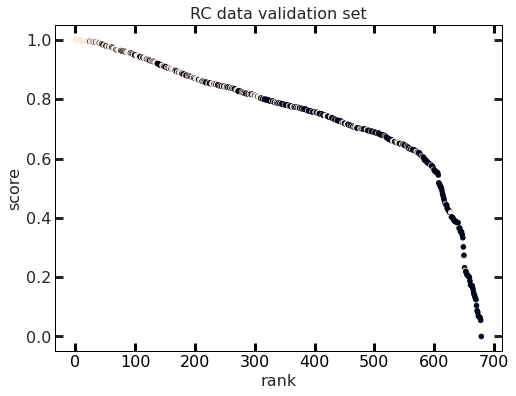

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,6))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
plt.rcParams.update({'font.size': 16})
ax.set_xlabel({'size':'18'} )
ax.set_ylabel({'size':'18'} )
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
x=np.arange(len(pub))
plt.scatter(x ,pub_val_sort.score, c=pub_val_sort.color)
#plt.ylim(-10,0)
#plt.axhline(y=0.9, label='Threshold', c='r', linewidth=4)
plt.ylabel('score', fontsize=16)
plt.xlabel('rank', fontsize=16)
plt.title('RC data validation set')
#plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/rc_fingerprint2_colorplot.png', bbox_inches='tight' ,dpi=600)

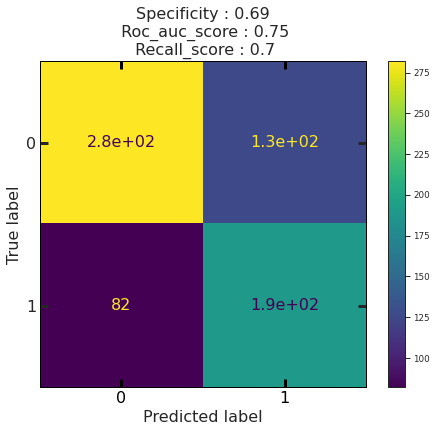

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,6))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
plt.rcParams.update({'font.size': 16})
ax.set_xlabel({'size':'18'} )
ax.set_ylabel({'size':'18'} )
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# Public available
y_pred  =[1 if i>=0.8 else 0 for i in pub_val_sort.score.values]
y_test = pub_val_sort.color.values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
roc_auc = roc_auc_score(rc_label, -1*ae_score(deep_SVDD, rc_df.iloc[:,2:].values).cpu().detach().numpy())
recall=recall_score(y_test, y_pred)
ax.set_title('Specificity : ' + str(round(specificity,2)) +
             '\n Roc_auc_score : '+ str(round(roc_auc,2)) +
             '\n Recall_score : ' +  str(round(recall,2)) )


cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=(0,1)).plot(ax=ax)
#plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/rc_fingerprint_confusion_matrix.png', bbox_inches='tight' ,dpi=600)

0.7474589100346021


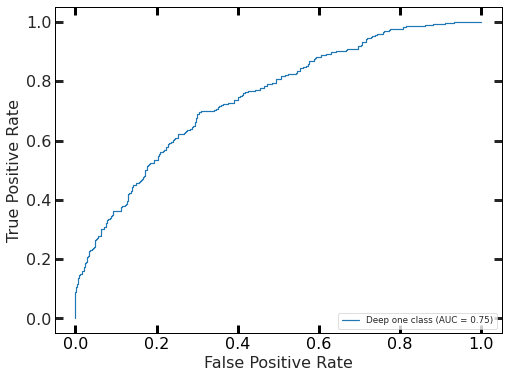

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,6))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
plt.rcParams.update({'font.size': 16})
ax.set_xlabel({'size':'18'} )
ax.set_ylabel({'size':'18'} )
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
roc_auc = roc_auc_score(rc_label, -1*ae_score(deep_SVDD, rc_df.iloc[:,2:].values).cpu().detach().numpy())

print(roc_auc)
fpr, tpr, _ = roc_curve(rc_label, -1*ae_score(deep_SVDD, rc_df.iloc[:,2:].values).cpu().detach().numpy())
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Deep one class').plot(ax=ax)
#plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/rc_fingerprint2_auc.png', bbox_inches='tight' ,dpi=600)

In [ ]:
# Public data validation

pub = -1*ae_score(deep_SVDD, grecu_df.iloc[:,2:].values).cpu().detach().numpy()
pub1 = X_scaler.transform(pub.reshape(-1,1))
pub_validation=pd.concat([pd.DataFrame(pub1, columns=['score']), pd.DataFrame(label.values, columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)

Text(0.5, 1.0, 'Grecu data validation set')

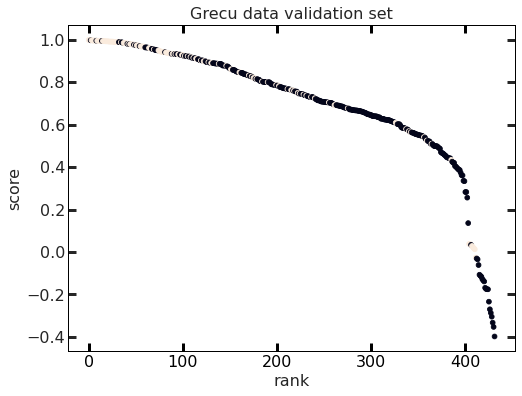

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,6))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
plt.rcParams.update({'font.size': 16})
ax.set_xlabel({'size':'18'} )
ax.set_ylabel({'size':'18'} )
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
x=np.arange(len(pub))
plt.scatter(x ,pub_val_sort.score, c=pub_val_sort.color)
#plt.ylim(-10,0)
#plt.axhline(y=0.9, label='Threshold', c='r', linewidth=4)
plt.ylabel('score')
plt.xlabel('rank')
plt.title('Grecu data validation set')
#plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/grecu_fingerprint2_colorplot.png', bbox_inches='tight' ,dpi=600)

In [ ]:
#grecu_scores = pd.concat([grecu_df.iloc[:,:2], pub_validation], axis=1)
#grecu_scores.to_csv('/content/drive/MyDrive/ccdc_ml_cocrystals/PublicallyAvalibleData/PublicallyAvailable_validation_set/grecu_scores_fingerprint.csv')

0.7867833294957403


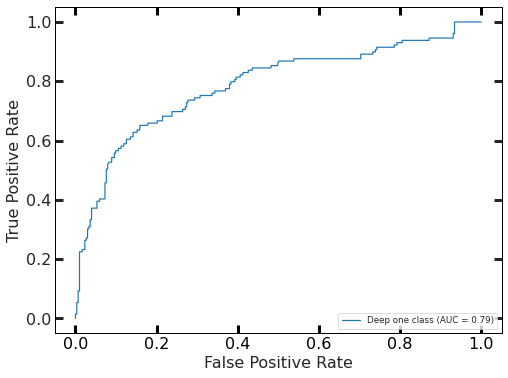

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,6))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
plt.rcParams.update({'font.size': 16})
ax.set_xlabel({'size':'18'} )
ax.set_ylabel({'size':'18'} )
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
roc_auc = roc_auc_score(label, -1*ae_score(deep_SVDD, grecu_df.iloc[:,2:].values).cpu().detach().numpy())

print(roc_auc)
fpr, tpr, _ = roc_curve(label, -1*ae_score(deep_SVDD, grecu_df.iloc[:,2:].values).cpu().detach().numpy())
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Deep one class').plot(ax=ax)
#plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/grecu_fingerprint2_auc.png', bbox_inches='tight' ,dpi=600)

In [ ]:
def plot_apis(api):

  test = rc_df[rc_df['Name 1']==i]
  #print(test.shape)
  test_label = rc_label.iloc[test.index]
  rc = ae_score(deep_SVDD, test.iloc[:,2:].values).cpu().detach().numpy()*-1
  rc1 = X_scaler.fit_transform(rc.reshape(-1,1))
  rc_validation=pd.concat([pd.DataFrame(rc1, columns=['score']), pd.DataFrame(test_label.values, columns=['color'])], axis=1)
  rc_val_sort = rc_validation.sort_values(by='score', ascending=False)
  x=np.arange(len(rc1))
  #plt.scatter(x ,rc_val_sort.score, c=rc_val_sort.color, cmap='viridis')
  #plt.ylim(0,1)
  #plt.axhline(y=0.8, label='Threshold', c='r', linewidth=4)
  #plt.ylabel('score')
  #plt.xlabel('rank')
  #plt.title('%s'%api)
  roc_auc = roc_auc_score(test_label, -1*ae_score(deep_SVDD,test.iloc[:,2:].values).cpu().detach().numpy())

  fpr, tpr, _ = roc_curve(test_label, -1*ae_score(deep_SVDD, test.iloc[:,2:].values).cpu().detach().numpy())
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Deep one class').plot()
  #plt.show()

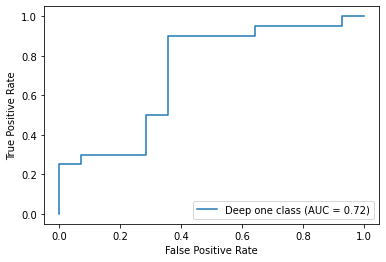

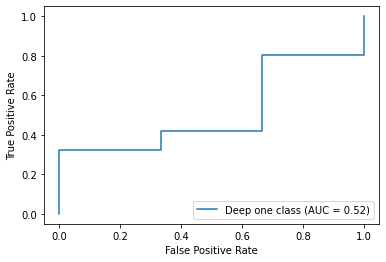

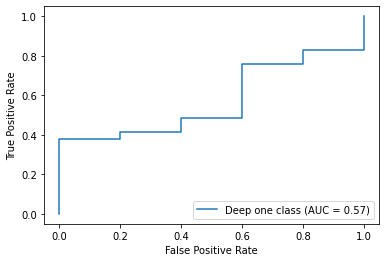

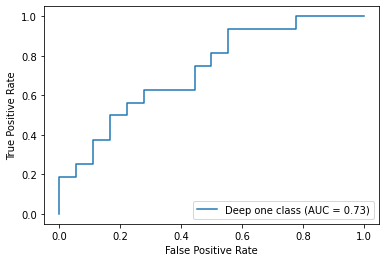

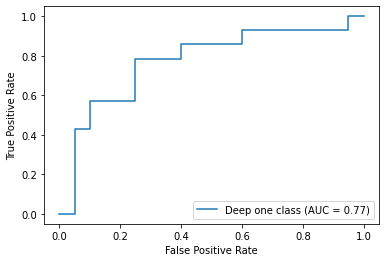

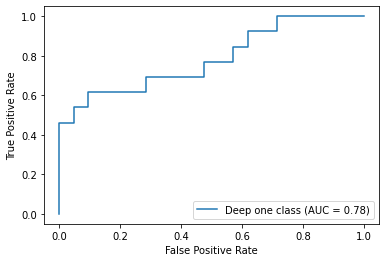

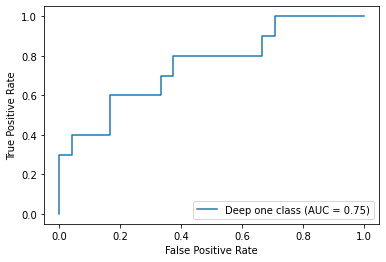

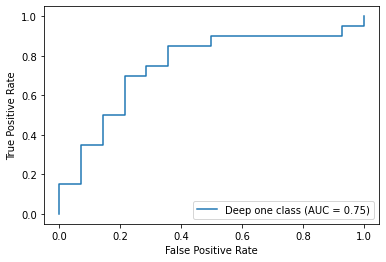

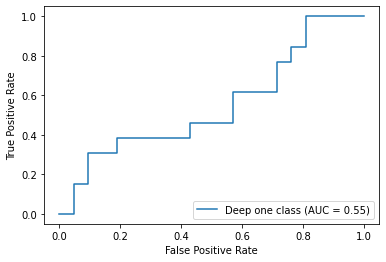

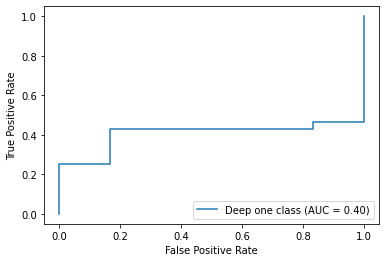

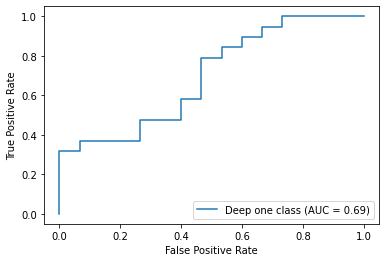

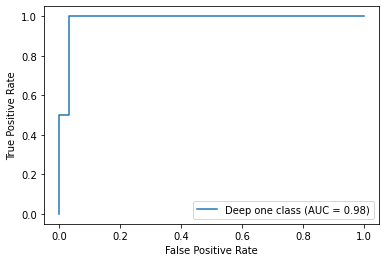

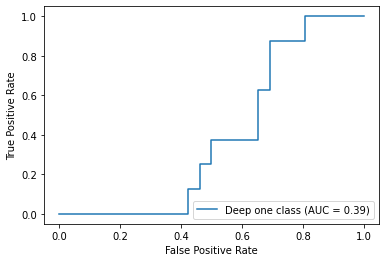

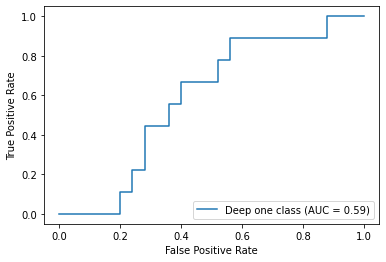

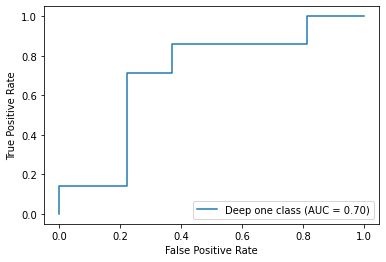

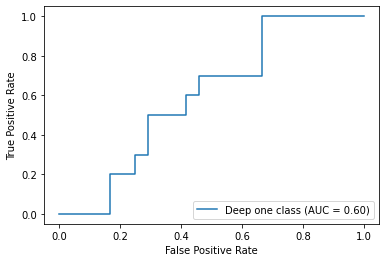

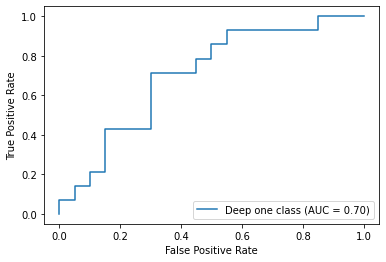

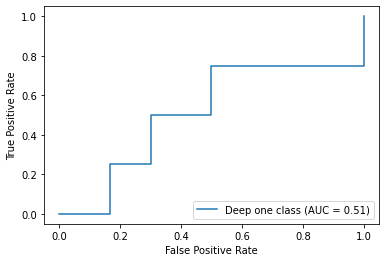

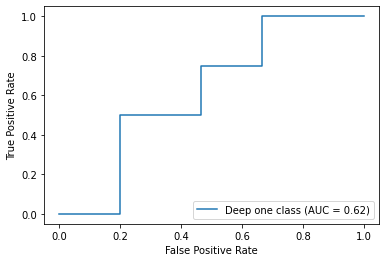

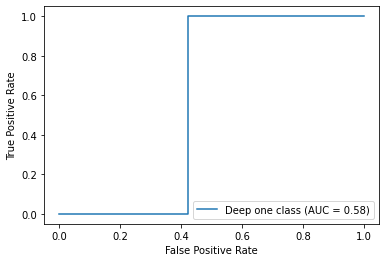

In [ ]:
# Evaluate per API
api_list= rc_df[['Name 1']].drop_duplicates(['Name 1']).values.ravel()

for i in api_list[:]:
  mc_df =rc_df[rc_df['Name 1']==i]
  score_mc = -1*ae_score(deep_SVDD, mc_df.iloc[:,2:].values).cpu().detach().numpy()
  #print(score_mc)
  #score_mc = clf.decision_function(mc_df.iloc[:,2:].values)*-1
  true_label = rc_label.loc[mc_df.index]
  roc_auc_mc = roc_auc_score(true_label, score_mc)
  #print(i, roc_auc_mc)
  plot_apis(i)

In [ ]:
def plot_apis(api):
  #fig, (ax1, ax2) = plt.subplots(2)
  test = grecu_df[grecu_df['Name 1']==i]
  test_label = label.iloc[test.index]
  rc = ae_score(deep_SVDD, test.iloc[:,2:].values).cpu().detach().numpy()*-1
  rc1 = X_scaler.fit_transform(rc.reshape(-1,1))
  rc_validation=pd.concat([pd.DataFrame(rc1, columns=['score']), pd.DataFrame(test_label.values, columns=['color'])], axis=1)
  rc_val_sort = rc_validation.sort_values(by='score', ascending=False)
  x=np.arange(len(rc1))
  #ax2.scatter(x ,rc_val_sort.score, c=rc_val_sort.color, cmap='viridis')
  #plt.ylim(0,1)
  #plt.axhline(y=0.8, label='Threshold', c='r', linewidth=4)
  #ax2.ylabel('score')
  #ax2.xlabel('rank')
  #ax2.title('%s'%api)
  plt.show()
  roc_auc = roc_auc_score(test_label, -1*ae_score(deep_SVDD,test.iloc[:,2:].values).cpu().detach().numpy())

  fpr, tpr, _ = roc_curve(test_label, -1*ae_score(deep_SVDD, test.iloc[:,2:].values).cpu().detach().numpy())
  #roc_display = plot_roc_curve(test_label ,-1*ae_score(deep_SVDD,test.iloc[:,2:].values).cpu().detach().numpy())
  #roc_display.plot(ax=ax1, alpha=0.8)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='%s'%i).plot()

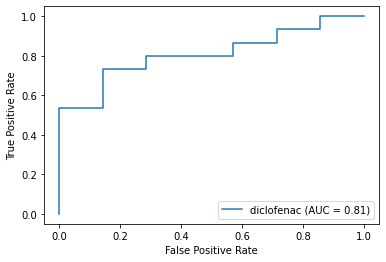

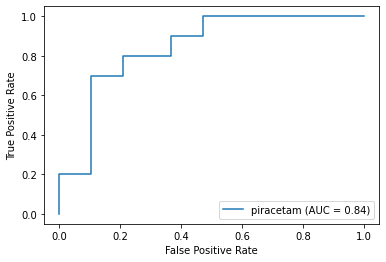

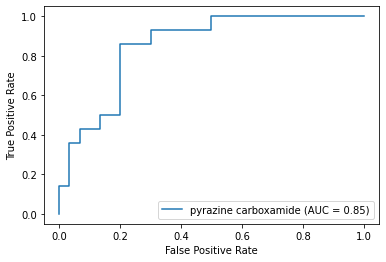

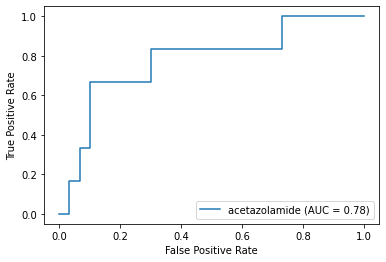

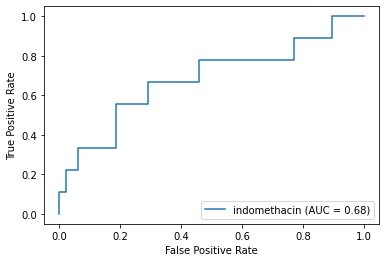

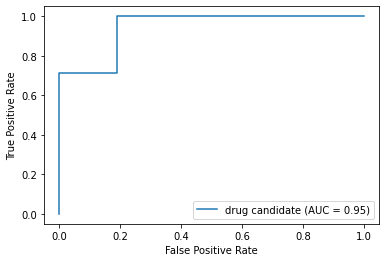

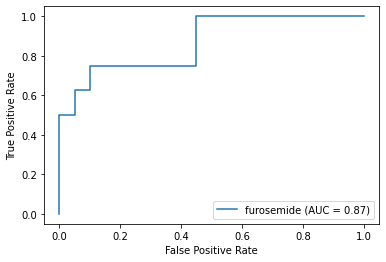

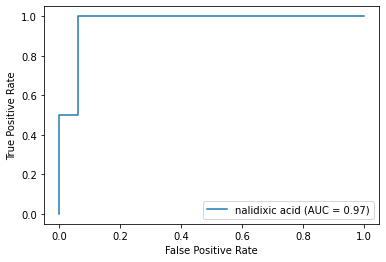

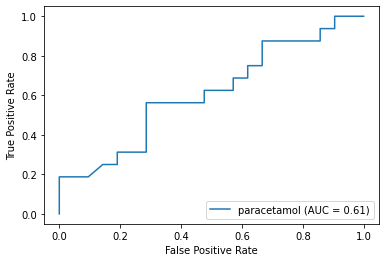

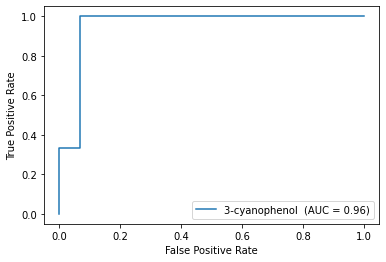

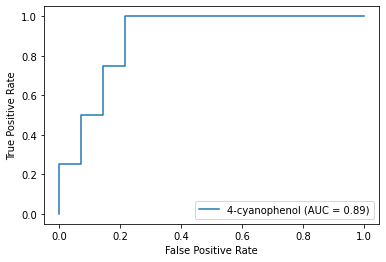

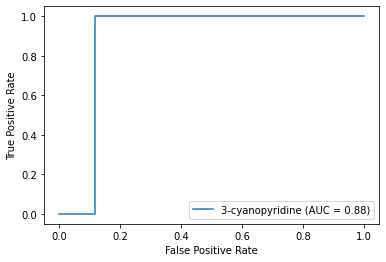

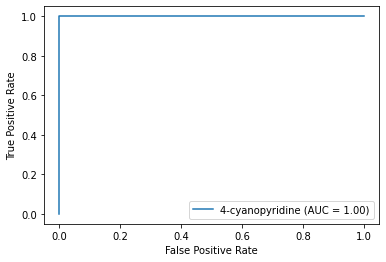

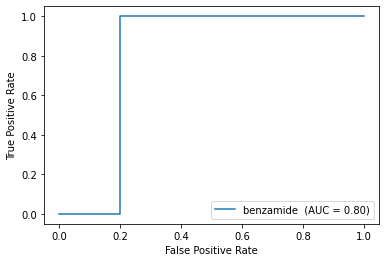

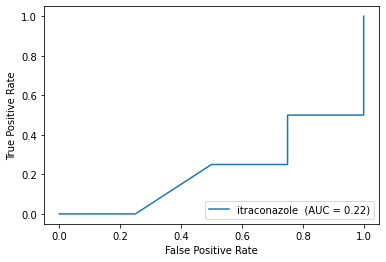

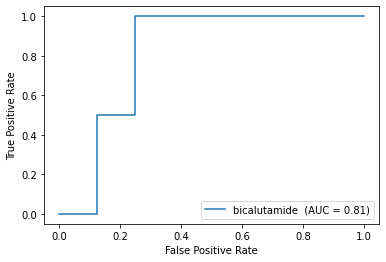

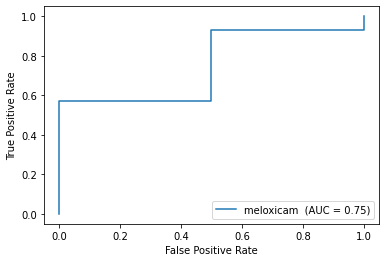

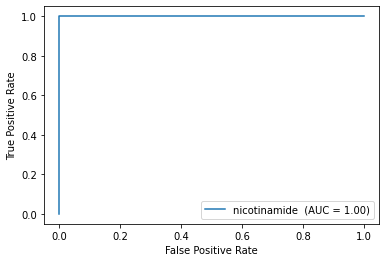

In [ ]:
# Evaluate per API
api_list= grecu_df[['Name 1']].drop_duplicates(['Name 1']).values.ravel()

for i in api_list[:]:
  mc_df =grecu_df[grecu_df['Name 1']==i]
  score_mc = -1*ae_score(deep_SVDD, mc_df.iloc[:,2:].values).cpu().detach().numpy()
  #score_mc = clf.decision_function(mc_df.iloc[:,2:].values)*-1
  true_label = label.loc[mc_df.index]
  try:
    roc_auc_mc = roc_auc_score(true_label, score_mc)
    #print(i, roc_auc_mc)
    plot_apis(i)
  except:
    pass

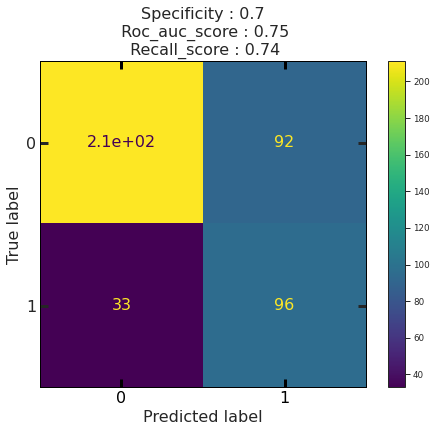

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(8,6))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
plt.rcParams.update({'font.size': 16})
ax.set_xlabel({'size':'18'} )
ax.set_ylabel({'size':'18'} )
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# Public available
y_pred  =[1 if i>=0.8 else 0 for i in pub_val_sort.score.values]
y_test = pub_val_sort.color.values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
roc_auc = roc_auc_score(rc_label, -1*ae_score(deep_SVDD, rc_df.iloc[:,2:].values).cpu().detach().numpy())
recall=recall_score(y_test, y_pred)
ax.set_title('Specificity : ' + str(round(specificity,2)) +
             '\n Roc_auc_score : '+ str(round(roc_auc,2)) +
             '\n Recall_score : ' +  str(round(recall,2)) )


cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=(0,1)).plot(ax=ax)
#plt.savefig('/content/drive/MyDrive/ccdc_ml_cocrystals/Figures/grecu_fingerprint_confusion_matrix.png', bbox_inches='tight' ,dpi=600)

# Shapley


In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 9.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491626 sha256=7aeac420a86a5ebdf56530e6d98d22d3465e9fd771097f352f309764b6344fd4
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
def ae_score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.ae_net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        scores = nakius_score(X, y)
    return scores

In [ ]:
def nakius_score(y_pred, y_true):
  split_idx = y_true.shape[1]//2
  flip = y_true[:, list(range(split_idx, split_idx * 2)) + list(range(split_idx))]
  scores_1 = torch.sum((y_pred - y_true) ** 2, dim=tuple(range(1, y_pred.dim())))
  scores_2 = torch.sum((y_pred - flip) ** 2, dim=tuple(range(1, y_pred.dim())))#
  scores = torch.min(scores_1, scores_2)
  return scores

In [ ]:
from optim.ae_trainer import nakius_score

In [ ]:
class  CocryNet(nn.Module):
    def __init__(self, ae_net):
      
        super().__init__()
        self.ae_net = ae_net
 
    def forward(self, x):
        outputs = self.ae_net(x)
        scores = F.mse_loss(outputs, x, reduction='none').mean(axis=1)*-1  #F.mse_loss(outputs, x, reduction='none').mean(axis=1)*-1 #nakius_score(outputs, x) #F.mse_loss(outputs, x, reduction='none').mean(axis=1)
        return scores.unsqueeze(1)

shapNet = CocryNet(deep_SVDD.ae_net)

In [ ]:
class  CocryNet(nn.Module):
    def __init__(self, net, R, C):
      
        super().__init__()
        self.net = net
        self.R = torch.Tensor([R]).to("cuda")
        self.C = torch.Tensor([C]).to("cuda")

    def forward(self, x):
        outputs = self.net(x)
        dist = torch.sum((outputs - self.C) ** 2, dim=1)
        scores = (dist - self.R ** 2)*-1
        return scores.unsqueeze(1)
shapNet = CocryNet(deep_SVDD.net, deep_SVDD.R, deep_SVDD.c)

In [ ]:
def concat_bidirectional(dataset1, dataset2):

  return pd.concat([pd.concat([dataset1, dataset2], axis=1), pd.concat([dataset2, dataset1], axis=1) ])


In [ ]:
df_bi=concat_bidirectional(kat_paws_from_df(df1[:], 'paws_1'), kat_paws_from_df(df2[:], 'paws_2'))

In [ ]:
# Interpretability of the whole bidirectional dataset
import shap

import numpy as np

# select a set of background examples to take an expectation over
device = 'cuda'
background = torch.FloatTensor(df_paws.iloc[:, :].values).to(device) 
model = shapNet.to(device)

# explain predictions of the model on the training set
e = shap.GradientExplainer(model, background)#, link = 'logit')      

#back = torch.FloatTensor(df_paws3.iloc[:, :].values).to(device) 
#e = shap.KernelExplainer(model, background)
shap_values = e.shap_values(torch.FloatTensor(df_paws.iloc[:120, :].values).to(device) , rseed=1, ranked_outputs=10)

In [ ]:
df_paws3 = df_paws.loc[cocrystals[cocrystals.group==3].index]

In [ ]:
cocrystals[cocrystals.group==2]#.index

csd_id  ... group
2     MTHMAD  ...     2
7     ADBURM  ...     2
9     DGUBCY  ...     2
10    ICYTIN  ...     2
15    QUIDON  ...     2
...      ...  ...   ...
7474  UKITEQ  ...     2
7475  UKITUG  ...     2
7476  UKIVIW  ...     2
7477  ULECEW  ...     2
7478  ULOLIT  ...     2

[5796 rows x 7 columns]

In [ ]:
np.count_nonzero(df_paws.paws_2_2722)

570

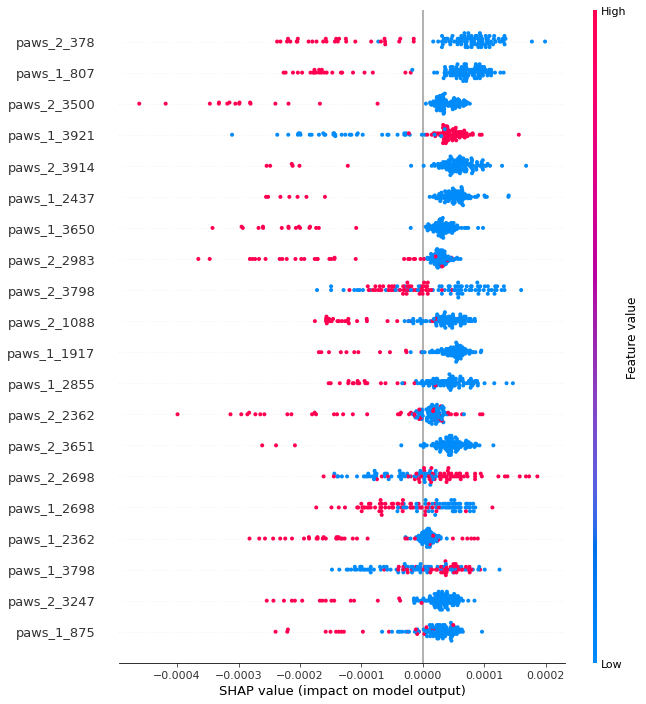

In [ ]:
# Plot the most important features 

X = df_paws.iloc[:120, :]                                                                                                                                                                                                                                   
shap.summary_plot(shap_values, X ,  color_bar=True, plot_size=(10,12), layered_violin_max_num_bins=30, class_names=None, max_display=20,  show=False)

In [ ]:
cols = df_paws.columns.values
tobi = pd.DataFrame(shap_values[2].reshape(1, -1), columns = df_paws.columns.values)
tobi

IndexError: ignored

In [ ]:
tobi

paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0       0.0       0.0  0.004246  ...          0.0          0.0     0.003749

[1 rows x 8192 columns]

In [ ]:
shap.initjs()
shap.force_plot(0,tobi.values, tobi.columns.values)

In [ ]:
shap.initjs()
#base = lab.mean()
tobi2 = tobi[tobi[cols] > 0.00009].dropna(axis=1)
shap.force_plot(-10, tobi2.values, tobi2.iloc[:,:])

In [ ]:
shap.initjs()
#base = lab.mean()
tobi2 = tobi[tobi[cols] < -0.09].dropna(axis=1)
shap.force_plot(-0.8, tobi2.values, tobi2.iloc[:,:])

In [ ]:
tobi = pd.DataFrame(shap_values[0].reshape(1, -1), columns = cols)


tobi1 = tobi.loc[:, (tobi != 0).any(axis=0)]
tobi1= tobi[tobi[cols] > 0.00009].dropna(axis=1)
tobi2 = tobi[tobi[cols] < -0.09].dropna(axis=1)
shap.initjs()
base = 0#unlab.values.mean()
tobi8= pd.concat([tobi1, tobi2], axis=1)
shap.force_plot(base, tobi8.values, tobi8.columns.values)

In [ ]:
cocry1 = cocrystals[cocrystals.group==1]
cocry1

csd_id  ... group
0     IANNOB  ...     1
1     CLAHMB  ...     1
3     PERFAN  ...     1
4     ANCTNB  ...     1
5     HBTBBZ  ...     1
...      ...  ...   ...
7425  EJUTOV  ...     1
7426  EKOQAZ  ...     1
7445  MAFMAL  ...     1
7467  OKURIY  ...     1
7468  OKUROE  ...     1

[973 rows x 7 columns]

In [ ]:
grecu_positives = grecu_df.loc[label==1]
grecu_negatives = grecu_df.loc[label==0]
grecu_negatives

Name 1                          Name2  ...  paws_2_4094  paws_2_4095
6       diclofenac           3,5-dimethylpyrazole  ...            0            0
8       diclofenac             2-chloropyrimidine  ...            0            0
13      diclofenac                       Pyrazole  ...            0            0
15      diclofenac                 4-iodopyrazole  ...            0            0
18      diclofenac  3,5-dimethyl-4-chloropyrazole  ...            0            0
..             ...                            ...  ...          ...          ...
416     meloxicam                  Tartaric acidÿ  ...            0            0
422     meloxicam                   Ascorbic acid  ...            0            0
429  nicotinamide                    Paracetamolÿ  ...            0            0
430  nicotinamide                      Ketoprofen  ...            0            0
431  nicotinamide                       Piracetam  ...            0            0

[303 rows x 8194 columns]

In [ ]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

X = pd.concat([grecu_positives.iloc[:, 2:],grecu_negatives.iloc[:, 2:]], axis=0)
y = np.concatenate([np.ones(grecu_positives.shape[0]), np.zeros(grecu_negatives.shape[0])])

random_forest = RandomForestRegressor(max_depth=15, random_state=0)
random_forest.fit(X, y)

#print(random_forest.predict(X))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
choosen_instance

paws_1_0  paws_1_1  paws_1_2  ...  paws_2_4093  paws_2_4094  paws_2_4095
0         0         0         0  ...            0            0            0

[1 rows x 8192 columns]

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(random_forest)

choosen_instance = X.loc[[0]]
shap_values = explainer.shap_values(choosen_instance)
#shap.initjs()
shap.force_plot(0, shap_values, choosen_instance)

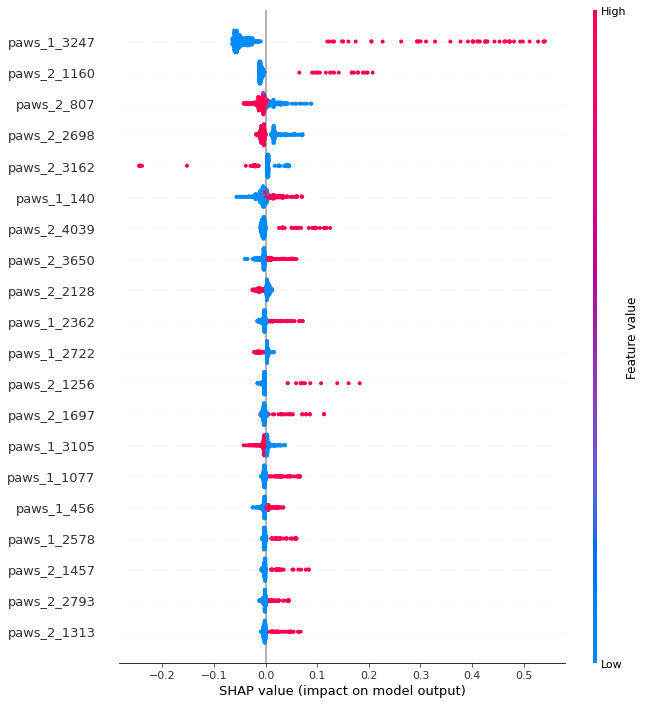

In [ ]:
# Plot the most important features 
                                                                                                                                                                                                                               
shap.summary_plot(shap_values, X ,  color_bar=True, plot_size=(10,12))#, layered_violin_max_num_bins=30, class_names=None, max_display=120,  show=False)

In [ ]:
tza = np.ones([1 , 8192])

tza.shape

(1, 8192)

In [ ]:
#-1*
ae_score(deep_SVDD, tza).cpu().detach().numpy()

array([7920.2886], dtype=float32)

In [ ]:
-1*ae_score(deep_SVDD, grecu_positives.iloc[:,2:].values).cpu().detach().numpy()

array([-3.24923062e+00, -4.08033514e+00, -1.95123935e+00, -8.51892281e+00,
       -1.06339538e+00, -1.03162804e+01, -2.06401005e+01, -2.70998812e+00,
       -8.41009903e+00, -1.29706497e+01, -1.47194805e+01, -3.32446647e+00,
       -2.26159191e+01, -7.09273911e+00, -1.81797829e+01, -5.12264156e+00,
       -3.09777212e+00, -4.05300188e+00, -4.05130863e+00, -3.03358030e+00,
       -7.98479652e+00, -4.48722982e+00, -5.04980087e+00, -3.06302214e+00,
       -9.74036407e+00, -1.68719399e+00, -2.59255290e+00, -1.01017749e+00,
       -1.07012939e+00, -7.98291111e+00, -1.01061893e+00, -2.11955976e+00,
       -1.13587809e+00, -1.07444000e+00, -1.49090314e+00, -2.02743101e+00,
       -2.24327540e+00, -1.01387775e+00, -1.54961598e+00, -7.98138952e+00,
       -1.98431087e+00, -3.54744606e+01, -1.21174431e+01, -2.04402199e+01,
       -4.87409644e-02, -3.84876175e+01, -1.63527851e+01, -2.88149719e+01,
       -1.70648651e+01, -2.53372097e+01, -3.30627060e+00, -8.90319633e+00,
       -1.61547890e+01, -

In [ ]:
grecu_pos_shap_values = e.shap_values(torch.FloatTensor(grecu_positives.iloc[:, 2:].values).to(device) , rseed=2)#, ranked_outputs=10)

In [ ]:
tobi = pd.DataFrame(grecu_pos_shap_values[0].reshape(1, -1), columns = cols)

In [ ]:
np.nonzero(grecu_positives.iloc[0, 2:].values)[0]

array([ 325,  342,  491,  561,  701,  807,  914,  974, 1088, 1224, 1380,
       1407, 1597, 1674, 1683, 1737, 1917, 2000, 2128, 2414, 2429, 2437,
       2698, 2855, 3087, 3200, 3247, 3397, 3627, 3744, 3798, 3921, 4218,
       4258, 4418, 4474, 4480, 4560, 4771, 4791, 4937, 5256, 5476, 5632,
       5827, 5951, 6013, 6030, 6052, 6117, 6390, 6862, 6925, 6975, 7040,
       7079, 7171, 7201, 7596, 7760, 7781, 7866, 7894, 7898, 8017])

In [ ]:
np.nonzero(grecu_positives.iloc[0, 2:].values)[0]-4096

array([-3771, -3754, -3605, -3535, -3395, -3289, -3182, -3122, -3008,
       -2872, -2716, -2689, -2499, -2422, -2413, -2359, -2179, -2096,
       -1968, -1682, -1667, -1659, -1398, -1241, -1009,  -896,  -849,
        -699,  -469,  -352,  -298,  -175,   122,   162,   322,   378,
         384,   464,   675,   695,   841,  1160,  1380,  1536,  1731,
        1855,  1917,  1934,  1956,  2021,  2294,  2766,  2829,  2879,
        2944,  2983,  3075,  3105,  3500,  3664,  3685,  3770,  3798,
        3802,  3921])

In [ ]:
shap.initjs()
#base = lab.mean()
tobi2 = tobi[tobi[cols] > 0.000005].dropna(axis=1)
shap.force_plot(0.8, tobi2.values, pd.DataFrame(grecu_positives[tobi2.columns.values].iloc[0, :].values.reshape(1, -1), columns = tobi2.columns.values))
#tobi2

In [ ]:
shap.initjs()
#base = lab.mean()
tobi2 = tobi[tobi[cols] < -0.000074].dropna(axis=1)
shap.force_plot(-0.000005, tobi2.values, tobi2.iloc[:,:] )
#tobi2

In [ ]:
tobi[tobi[cols]  > 0].dropna(axis=1).values.sum()

14.33272981076734

In [ ]:
tobi[tobi[cols]  < 0].dropna(axis=1).values.sum()

-11.178625286075984

In [ ]:
from rdkit.Chem import Draw

mol1 = Chem.MolFromSmiles('OC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl')
mol2 = Chem.MolFromSmiles('COc1ccc(cc1)C1=NN2C=C(C)N=C2S1')
mol= Chem.MolFromSmiles('CC1=NN2C=C(C)N=C2S1')
#Nc1ccc(I)cc1.O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O

In [ ]:
def LoveYouNakiusMou(mol, bits, bit_info):
  atomsToUse = set()
  for bit in bits:
    for (atom_id, _) in bit_info[bit]:
      atomsToUse.add(atom_id)
  atomsToUse = list(atomsToUse)
  print(atomsToUse)
  d = Draw.rdMolDraw2D.MolDraw2DSVG(500, 500)
  Draw.rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=atomsToUse)
  return d

[0]


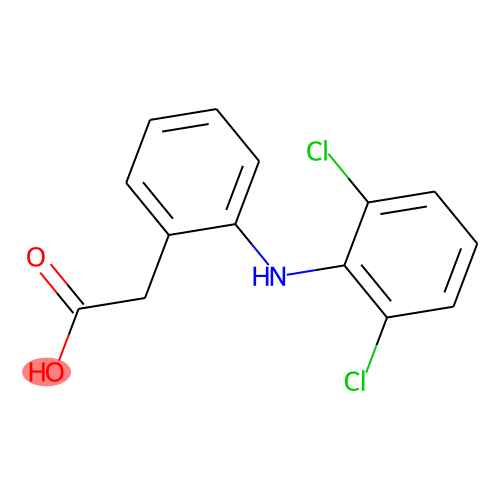

In [ ]:
mol = Chem.MolFromSmiles('COc1ccc(cc1)C1=NN2C=C(C)N=C2S1')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096, useChirality=True,bitInfo=bi)
d =LoveYouNakiusMou(mol1, [ 841,  1380,
], bi)
d.FinishDrawing()
SVG(d.GetDrawingText().replace('svg:', ''))

In [ ]:
kat_paws_from_df(grecu.Smiles2.values[:1], 'paws_2')
np.nonzero(kat_paws_from_df(grecu.Smiles2.values[:1], 'paws_2').values)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 122,  162,  322,  378,  384,  464,  675,  695,  841, 1160, 1380,
        1536, 1731, 1855, 1917, 1934, 1956, 2021, 2294, 2766, 2829, 2879,
        2944, 2983, 3075, 3105, 3500, 3664, 3685, 3770, 3798, 3802, 3921]))

In [ ]:
mol = Chem.MolFromSmiles(grecu.Smiles2.values[0])
tza = np.asarray(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096, useChirality=True))
np.nonzero(tza)

(array([ 122,  162,  322,  378,  384,  464,  675,  695,  841, 1160, 1380,
        1536, 1731, 1855, 1917, 1934, 1956, 2021, 2294, 2766, 2829, 2879,
        2944, 2983, 3075, 3105, 3500, 3664, 3685, 3770, 3798, 3802, 3921]),)

In [ ]:
grecu.Smiles2.values[0]
mol = Chem.MolFromSmiles('COc1ccc(cc1)C1=NN2C=C(C)N=C2S1')

In [ ]:
from rdkit.Chem import rdMolDescriptors
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096, useChirality=True)
# rdMolDescriptors.GetMorganFingerprintAsBitVect(mol2, 2, nBits=4096, useChirality=True, bitInfo=bi)
# show 10 of the set bits:
list(fp.GetOnBits())[:]

[122,
 162,
 322,
 378,
 384,
 464,
 675,
 695,
 841,
 1160,
 1380,
 1536,
 1731,
 1855,
 1917,
 1934,
 1956,
 2021,
 2294,
 2766,
 2829,
 2879,
 2944,
 2983,
 3075,
 3105,
 3500,
 3664,
 3685,
 3770,
 3798,
 3802,
 3921]

In [ ]:
from rdkit.Chem.Draw import IPythonConsole
Draw.DrawMorganBit(mol,3500,bi)

KeyError: ignored

In [ ]:
bi = {}
tpls = [(mol,x,bi) for x in fp.GetOnBits()]
Draw.DrawMorganBits(tpls[:12],molsPerRow=4,legends=[str(x) for x in fp.GetOnBits()][:12])

KeyError: ignored

In [ ]:

tobi = pd.DataFrame(shap_values[2].reshape(1, -1), columns = cols)


tobi1 = tobi.loc[:, (tobi != 0).any(axis=0)]
tobi1= tobi[tobi[cols]  > 0.000009].dropna(axis=1)
tobi2 = tobi[tobi[cols] <  -0.00001].dropna(axis=1)
shap.initjs()
base = 0.8 #unlab.values.mean()
tobi8= pd.concat([tobi1, tobi2], axis=1)
shap.force_plot(base, tobi8.values, tobi8.columns.values)

In [ ]:
shap_val=np.mean(shap_values, 0)
shap_matrix= pd.DataFrame(shap_val, columns=['score'], index=X.columns.values)
shap_matrix



In [ ]:
# Keeping only the most important descriptors that lead to score increase (high_shap) and those that lead to decrease(low_shap).

#shap_matrix = shap_matrix[~shap_matrix.index.str.contains("_2")]
high_shap = shap_matrix.head(30).index.str.replace('_1', '')
low_shap = shap_matrix.tail(30).index.str.replace('_1', '')


In [ ]:
top_important = high_shap + low_shap
top_important

In [ ]:
# Plot the most important features 

X = pd.DataFrame(df_paws.iloc[:, :])                                                                                                                                                                                                                                             :].values, columns=cols)  #df

shap.summary_plot(shap_values, X ,  color_bar=True, plot_size=(10,12), layered_violin_max_num_bins=30, class_names=None, max_display=60,  show=False)

#plt.savefig('shap_lab.svg')

NameError: ignored

In [ ]:
# Plot the most important features 

X = pd.DataFrame(df.iloc[:, 1:].values, columns=cols)  #df

shap.summary_plot(shap_values, X ,  color_bar=True, plot_size=(10,18), layered_violin_max_num_bins=30, class_names=None, max_display=60,  show=False)

plt.savefig('shap_lab.svg')


#Selfies


In [ ]:
!pip install selfies

In [ ]:
import selfies as sf 
benzene = "c1ccccc1"  
encoded_selfies = sf.encoder(benzene)
decoded_smiles = sf.decoder(encoded_selfies)
len_benzene = sf.len_selfies(encoded_selfies)
symbols_benzene = list(sf.split_selfies(encoded_selfies))

In [ ]:
encoded_selfies 

'[C][=C][C][=C][C][=C][Ring1][Branch1_2]'

In [ ]:
import selfies as sf

dataset = ['[C][O][C]', '[F][C][F]', '[O][=O]', '[C][C][O][C][C]']
alphabet = sf.get_alphabet_from_selfies(dataset)
alphabet.add('[nop]')  # '[nop]' is a special padding symbol
alphabet = list(sorted(alphabet))
print(alphabet)  # ['[=O]', '[C]', '[F]', '[O]', '[nop]']

pad_to_len = max(sf.len_selfies(s) for s in dataset)  # 5
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

# SELFIES to label encode
dimethyl_ether = dataset[0]  # '[C][O][C]'

# [1, 3, 1, 4, 4]
print(sf.selfies_to_encoding(dimethyl_ether,
                             vocab_stoi=symbol_to_idx,
                             pad_to_len=pad_to_len,
                             enc_type='label'))
                             
# [[0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]]
print(sf.selfies_to_encoding(dimethyl_ether,
                             vocab_stoi=symbol_to_idx,
                             pad_to_len=pad_to_len,
                             enc_type='one_hot'))

['[=O]', '[C]', '[F]', '[O]', '[nop]']
[1, 3, 1, 4, 4]
[[0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]]


In [ ]:
smiles_list = df1[:8]

In [ ]:
selfies_list = list(map(sf.encoder, smiles_list))

all_selfies_symbols = sf.get_alphabet_from_selfies(selfies_list)
all_selfies_symbols.add('[nop]')
selfies_alphabet = list(all_selfies_symbols)

largest_selfies_len = max(sf.len_selfies(s) for s in selfies_list)

print('Finished translating SMILES to SELFIES.')

#return selfies_list, selfies_alphabet, largest_selfies_len, \
 #          smiles_list, smiles_alphabet, largest_smiles_len

Finished translating SMILES to SELFIES.


In [ ]:
def multiple_selfies_to_hot(selfies_list, largest_molecule_len, alphabet):
    """Convert a list of selfies strings to a one-hot encoding
    """

    hot_list = []
    for s in selfies_list:
        _, onehot_encoded = selfies_to_hot(s, largest_molecule_len, alphabet)
        hot_list.append(onehot_encoded)
    return np.array(hot_list)

In [ ]:
def selfies_to_hot(selfie, largest_selfie_len, alphabet):
    """Go from a single selfies string to a one-hot encoding.
    """

    symbol_to_int = dict((c, i) for i, c in enumerate(alphabet))

    # pad with [nop]
    selfie += '[nop]' * (largest_selfie_len - sf.len_selfies(selfie))

    # integer encode
    symbol_list = sf.split_selfies(selfie)
    integer_encoded = [symbol_to_int[symbol] for symbol in symbol_list]

    # one hot-encode the integer encoded selfie
    onehot_encoded = list()
    for index in integer_encoded:
        letter = [0] * len(alphabet)
        letter[index] = 1
        onehot_encoded.append(letter)

    return integer_encoded, np.array(onehot_encoded)

In [ ]:
#selfies_to_hot(selfies_list[0],largest_selfies_len,selfies_alphabet)

In [ ]:
k=multiple_selfies_to_hot(selfies_list,largest_selfies_len,selfies_alphabet )
#.shape
k.shape

(8, 61, 16)

# Graphs

# Smiles tokens


In [ ]:
import deepchem as dc
tasks, datasets, transformers = dc.molnet.load_muv(split='stratified')
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids
valid_smiles = valid_dataset.ids

'split' is deprecated.  Use 'splitter' instead.


In [ ]:

train_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in train_smiles]

In [ ]:
df1 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in df1]
df2 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in df2]

In [ ]:
grecu_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in grecu['CCDC Smiles1'].values]

In [ ]:
grecu_smiles2 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in grecu['CCDC Smiles2'].values ]

In [ ]:
rc_smiles =[Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in np.concatenate([rc['Smiles1'].values, rc['Smiles2'].values]) ]

In [ ]:
add_smiles = np.concatenate([train_smiles , df1, df2, grecu_smiles, grecu_smiles2, rc_smiles ])
                             #, lmap['Smiles1 CCDC'],
                            # lmap['Smiles2 CCDC'], dicarboxylic_acids.Smiles1, dicarboxylic_acids.Smiles2])

In [ ]:
train_smiles = add_smiles

In [ ]:
tokens = set()
for s in train_smiles:
  tokens = tokens.union(set(c for c in s))
tokens = sorted(list(tokens))
tokens

['#',
 '%',
 '(',
 ')',
 '+',
 '-',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'B',
 'C',
 'F',
 'H',
 'I',
 'N',
 'O',
 'P',
 'S',
 'T',
 'X',
 '[',
 '\\',
 ']',
 'c',
 'e',
 'i',
 'l',
 'n',
 'o',
 'p',
 'r',
 's',
 't']

In [ ]:
from deepchem.models.optimizers import Adam, ExponentialDecay
max_length = max(len(s) for s in train_smiles)
batch_size = 100
batches_per_epoch = len(train_smiles)/batch_size
model = dc.models.SeqToSeq(tokens,
                           tokens,
                           max_length,
                           encoder_layers=2,
                           decoder_layers=2,
                           embedding_dimension=256,
                           model_dir='fingerprint',
                           batch_size=batch_size,
                           learning_rate=ExponentialDecay(0.001, 0.9, batches_per_epoch))

In [ ]:
def generate_sequences(epochs):
  for i in range(epochs):
    for s in train_smiles:
      yield (s, s)

model.fit_sequences(generate_sequences(40))

INFO:deepchem.models.keras_model:Ending global_step 100: Average loss 212.406
INFO:deepchem.models.keras_model:Ending global_step 200: Average loss 103.692
INFO:deepchem.models.keras_model:Ending global_step 300: Average loss 97.663
INFO:deepchem.models.keras_model:Ending global_step 400: Average loss 95.5773
INFO:deepchem.models.keras_model:Ending global_step 500: Average loss 95.139
INFO:deepchem.models.keras_model:Ending global_step 600: Average loss 99.165
INFO:deepchem.models.keras_model:Ending global_step 700: Average loss 92.8664
INFO:deepchem.models.keras_model:Ending global_step 800: Average loss 76.7868
INFO:deepchem.models.keras_model:Ending global_step 900: Average loss 62.4885
INFO:deepchem.models.keras_model:Ending global_step 1000: Average loss 81.1491
INFO:deepchem.models.keras_model:Ending global_step 1100: Average loss 87.2951
INFO:deepchem.models.keras_model:Ending global_step 1200: Average loss 85.9467
INFO:deepchem.models.keras_model:Ending global_step 1300: Averag

In [ ]:
predicted = model.predict_from_sequences(valid_smiles[:500])
count = 0
for s,p in zip(valid_smiles[:500], predicted):
  if ''.join(p) == s:
    count += 1
print('reproduced', count, 'of 500 validation SMILES strings')

reproduced 0 of 500 validation SMILES strings


In [ ]:
!pwd

/content


In [ ]:
%ls

conda_installer.py  fingerprint/                       __pycache__/
drive/              Miniconda3-latest-Linux-x86_64.sh  sample_data/


In [ ]:
model.save_checkpoint(model_dir="/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/embeddings_model/kat_checkpoint060420201")

In [ ]:
restore_kat =  dc.models.SeqToSeq(tokens,
                           tokens,
                           max_length,
                           encoder_layers=2,
                           decoder_layers=2,
                           embedding_dimension=256,
                           model_dir='/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/embeddings_model/kat_checkpoint060420201',
                           batch_size=batch_size,
                           learning_rate=ExponentialDecay(0.001, 0.9, batches_per_epoch))

In [ ]:
restore_kat.restore()

In [ ]:
import numpy as np
train_embeddings = model.predict_embeddings(train_smiles)
train_embeddings_dataset = dc.data.NumpyDataset(train_embeddings,
                                                train_dataset.y,
                                                train_dataset.w.astype(np.float32),
                                                train_dataset.ids)

valid_embeddings = model.predict_embeddings(valid_smiles)
valid_embeddings_dataset = dc.data.NumpyDataset(valid_embeddings,
                                                valid_dataset.y,
                                                valid_dataset.w.astype(np.float32),
                                                valid_dataset.ids)

AttributeError: ignored

In [ ]:
# Import the dataset which contains all the molecules that constitute the first coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

dataset1=pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/alvadesc_data/dataset1.csv')  
dataset2=pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/alvadesc_data/dataset2.csv') 
print(dataset1.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (51,72,73,74,75,76,77,78,79,80,81,154,157,158,305,306,307,308,309,311,312,313,331,337,338,339,340,341,343,344,345,365,366,367,368,369,370,371,372,373,395,396,397,398,399,401,402,403,426,427,428,429,430,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,517,524,525,526,527,528,530,531,532,551,558,559,560,561,562,564,565,566,585,592,593,594,595,596,598,599,600,619,626,627,628,629,630,632,633,634,653,660,661,662,663,664,666,667,668,687,694,695,696,697,698,700,701,702,727,728,729,730,731,733,734,735,760,761,762,763,764,766,767,768,793,794,795,796,797,799,800,801,826,827,828,829,830,832,833,834,859,860,861,862,863,865,866,867,892,893,894,895,896,898,899,900,3842,3847,3848,3849,3855,3856,3857,3858,3871,3872,3873,3874,38

(5522, 3887)


In [ ]:
def smile_to_paw(smile):
  return  restore_kat.predict_embeddings(smile)

def kat_paws(smiles):
  paws = []
  for smile in smiles:
    paws.append(smile_to_paw(smile).ravel())
  return paws

def kat_paws_from_df(smiles, prefix):
  df = pd.DataFrame(smile_to_paw(smiles))
  columns = [f'{prefix}_{i}' for i in df.columns]
  df.columns = columns
  return df

In [ ]:
df1 = dataset1.Smiles1.values[:]
df2 = dataset2.Smiles2.values[:]

AttributeError: ignored

In [ ]:
df_paws = pd.concat([kat_paws_from_df(df1, 'paws_1'), kat_paws_from_df(df2, 'paws_2')], axis=1)
df_paws

paws_1_0  paws_1_1  paws_1_2  ...  paws_2_253  paws_2_254  paws_2_255
0     0.241863 -0.116054 -0.789957  ...    0.203973   -0.002542   -0.023394
1     0.091451  0.193409 -0.783781  ...    0.103102    0.072357    0.110434
2     0.091451  0.193409 -0.783781  ...    0.231095    0.186712    0.106924
3     0.065833  0.005075 -0.822860  ...   -0.008819    0.075497    0.071989
4     0.091451  0.193409 -0.783781  ...    0.105800    0.105133    0.081931
...        ...       ...       ...  ...         ...         ...         ...
7598  0.068806 -0.237892  0.005686  ...    0.080703    0.143154   -0.013269
7599  0.001592 -0.027540 -0.754740  ...    0.167654   -0.062028   -0.012551
7600  0.039979  0.119437 -0.551155  ...    0.173922    0.150833    0.038257
7601  0.046446  0.129842  0.564029  ...   -0.187812    0.041689    0.127826
7602  0.038028  0.058733  0.506372  ...    0.303797    0.091938   -0.039778

[7603 rows x 512 columns]

In [ ]:
grecu_smiles1 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in grecu['CCDC Smiles1'].values ]
grecu_smiles2 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in grecu['CCDC Smiles2'].values ]

rc_smiles1 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in rc['Smiles1'].values ]
rc_smiles2 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in rc['Smiles2'].values ]

In [ ]:
# Grecu data

grecu = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/validation_set/public_available_data/PublicallyAvalibledata.csv', encoding='latin1')
label= grecu['Co-crystal']
grecu_smiles1 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in grecu['CCDC Smiles1'].values ]
grecu_smiles2 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in grecu['CCDC Smiles2'].values ]
grecu_df = pd.concat([grecu['Name 1'], grecu['Name2'],  kat_paws_from_df(grecu_smiles1, 'paws_1'), kat_paws_from_df(grecu_smiles2, 'paws_2')], axis=1)

In [ ]:
# RC data
rc= pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/validation_set/RC_data/RCcocrystals_training (1).csv')
rc_label= rc['Co-crystal']
rc_smiles1 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in rc['Smiles1'].values ]
rc_smiles2 = [Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in rc['Smiles2'].values ]
rc_df = pd.concat([rc['Name 1'], rc['Name2'], kat_paws_from_df(rc_smiles1, 'paws_1'), kat_paws_from_df(rc_smiles2, 'paws_2')], axis=1)

In [ ]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design-master/models/deep_one_class
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
import deepSVDD
from base.base_net import BaseNet

/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class
/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class/src/set_transformer
/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class/src


In [ ]:
class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if train:
          # Setup the train dataset
          self.data=data.values.astype('f')
          self.labels=np.zeros(self.data.shape[0])

        else:
          # Setup the test dataset
          self.data = grecu_df.iloc[:, 2:].values.astype('f') #public.iloc[:,2:].values.astype('f')# public.values.astype('f')
          self.labels = np.abs(label.values - 1)
         
    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)
        return self.decoder(self.encoder(x))

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [ ]:
class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=256, dim_out=100, num_heads=8),
              #SAB(dim_in=800, dim_out=400, num_heads=8),
             # SAB(dim_in=500, dim_out=100, num_heads=5),
            PMA(dim=100, num_heads=2, num_seeds=1))
        
    def forward(self, inp):
      x = torch.split(inp, 256, dim=1)     
      x= torch.stack(x).transpose(0,1)
      x = self.seq(x).squeeze()
      return x.view(inp.size(0), -1)

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( nn.Linear(in_features=100, out_features=256), nn.LeakyReLU(),
      # nn.Linear(in_features=400, out_features=800),nn.LeakyReLU(),
        # nn.Linear(in_features=500, out_features=1119),nn.LeakyReLU(),     
       nn.Linear(in_features=256, out_features=512), nn.Sigmoid())
        
        #nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())
        #nn.Sequential(nn.Linear(in_features=100, out_features=7224), nn.Sigmoid()))
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=256, dim_out=100, num_heads=2),
            PMA(dim=100, num_heads=1, num_seeds=1))
        
    def forward(self, inp):
      x = torch.split(inp, 256, dim=1)     
      x= torch.stack(x).transpose(0,1)
      x = self.seq(x).squeeze()
      return x.view(inp.size(0), -1)

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( nn.Sequential(nn.Linear(in_features=100, out_features=512), nn.Sigmoid()))
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 50
        self.seq = nn.Sequential(SAB(dim_in=256, dim_out=50, num_heads=10),
            PMA(dim=50, num_heads=2, num_seeds=1))
        
    def forward(self, inp):
      x = torch.split(inp, 256, dim=1)     
      x= torch.stack(x).transpose(0,1)
      x = self.seq(x).squeeze()
      return x.view(inp.size(0), -1)

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( nn.Sequential(nn.Linear(in_features=50, out_features=512), nn.Sigmoid()))
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()

def build_network(net_name):  
  return PairsEncoder()

torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [ ]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': 0, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [ ]:
df_paws.shape

(7603, 512)

In [ ]:
dataset_name = cfg.settings['dataset_name']
#data_path = cfg.settings['data_path']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
#xp_path = cfg.settings['xp_path']

dataset = Pairs_Dataset('', data= df_paws.iloc[:, :] )#df.iloc[:1600, 1:])  #load_dataset(dataset_name, data_path, normal_class) KatPair(df1_scaled, df2_scaled) #

In [ ]:
def set_seed():
  seed = cfg.settings.get('seed', 0)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [ ]:
set_seed()
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#lr=1e-4, n_epochs = 100 batch_size=100,
deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-4,
                   n_epochs = 100, #100,
                   lr_milestones=(100,),
                   batch_size= 50, 
                   weight_decay= 3e-06 ,#cfg.settings['ae_weight_decay'],  
                   device=device,
                   n_jobs_dataloader=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/100	 Time: 0.882	 Loss: 107.15387332
INFO:root:  Epoch 2/100	 Time: 0.866	 Loss: 36.35449790
INFO:root:  Epoch 3/100	 Time: 0.852	 Loss: 34.32993314
INFO:root

In [ ]:
deep_SVDD.net.is_pretrain = False

In [ ]:
# lr=1e-5, n_epochs = 220, batch_size=cfg.settings['batch_size']
#220 100 100 100
deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,  #1e-3
                n_epochs = 500,  # 50 #50 #50
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size= 50,#cfg.settings['batch_size'],
                weight_decay= 1e-06 ,#cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)

INFO:root:Initializing center c...
INFO:root:Center c initialized.
INFO:root:Starting training...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/500	 Time: 0.777	 Loss: 0.23532114
INFO:root:  Epoch 2/500	 Time: 0.785	 Loss: 0.14459961
INFO:root:  Epoch 3/500	 Time: 0.762	 Loss: 0.10862654
INFO:root:  Epoch 4/500	 Time: 0.763	 Loss: 0.08866759
INFO:root:  Epoch 5/500	 Time: 0.755	 Loss: 0.07461637
INFO:root:  Epoch 6/500	 Time: 0.752	 Loss: 0.06441396
INFO:root:  Epoch 7/5

In [ ]:
deep_SVDD.test(dataset)


INFO:root:Starting testing...
INFO:root:Testing time: 0.022
INFO:root:Test set AUC: 45.29%
INFO:root:Finished testing.


In [ ]:
from optim.ae_trainer import nakius_score

In [ ]:
def ae_score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.ae_net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        #print(y.dim(), y.shape, X.shape)
        scores = nakius_score(X, y)#torch.sum((y - X) ** 2, dim=tuple(range(1, y.dim())))
    return scores

In [ ]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [ ]:
# Evalute on the RC data
# Import evaluation libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
# Evaluate on the RC data
roc_auc = roc_auc_score(rc_label.values, -1*score(deep_SVDD, rc_df.iloc[:,2:].values).cpu().detach().numpy())
print('RC', roc_auc)

# Evaluate on the Grecu data
roc_auc = roc_auc_score(label.values, -1*score(deep_SVDD, grecu_df.iloc[:,2:].values).cpu().detach().numpy())
print('Grecu', roc_auc)

RC 0.6518526528258363
Grecu 0.4528753221649484


In [ ]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [ ]:
# Public data validation

pub = -1*score(deep_SVDD, rc_df.iloc[:,2:].values).cpu().detach().numpy()

pub_validation=pd.concat([pd.DataFrame(pub, columns=['score']), pd.DataFrame(rc_label.values, columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)

Text(0.5, 1.0, 'Public data validation set')

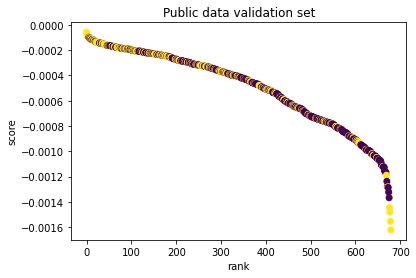

In [ ]:
x=np.arange(len(pub))
plt.scatter(x ,pub_val_sort.score, c=pub_val_sort.color)
#plt.ylim(-10,0)
#plt.axhline(y=0.9, label='Threshold', c='r', linewidth=4)
plt.ylabel('score')
plt.xlabel('rank')
plt.title('Public data validation set')


In [ ]:
def plot_apis(api):

  test = rc_df[rc_df['Name 1']==i]
  print(test.shape)
  test_label = rc_label.iloc[test.index]
  rc = score(deep_SVDD, test.iloc[:,2:].values).cpu().detach().numpy()*-1
  rc1 = rc  #y_scaler1.transform(rc.reshape(-1,1))
  rc_validation=pd.concat([pd.DataFrame(rc1, columns=['score']), pd.DataFrame(test_label.values, columns=['color'])], axis=1)
  rc_val_sort = rc_validation.sort_values(by='score', ascending=False)
  x=np.arange(len(rc1))
  plt.scatter(x ,rc_val_sort.score, c=rc_val_sort.color, cmap='viridis')
  #plt.ylim(0,1)
  #plt.axhline(y=0.8, label='Threshold', c='r', linewidth=4)
  plt.ylabel('score')
  plt.xlabel('rank')
  plt.title('%s'%api)
  plt.show()

(34, 514)


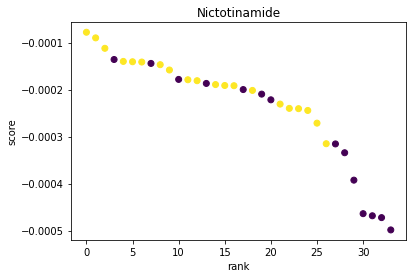

(34, 514)


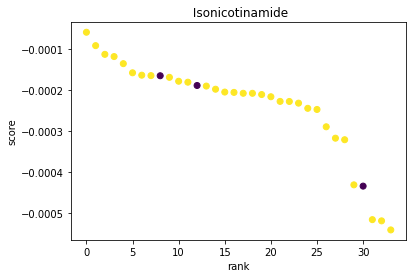

(34, 514)


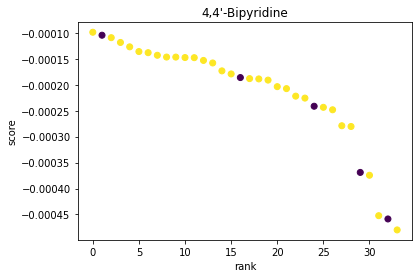

(34, 514)


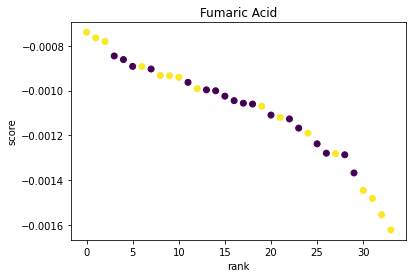

(34, 514)


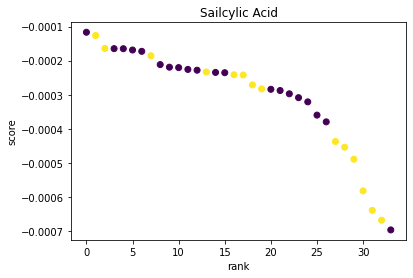

(34, 514)


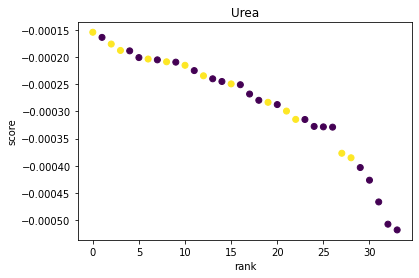

(34, 514)


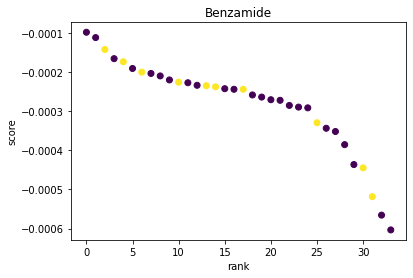

(34, 514)


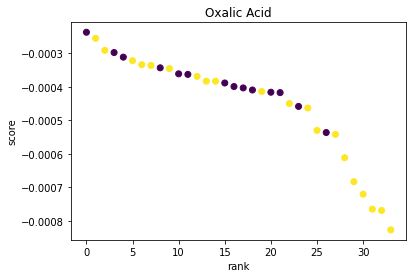

(34, 514)


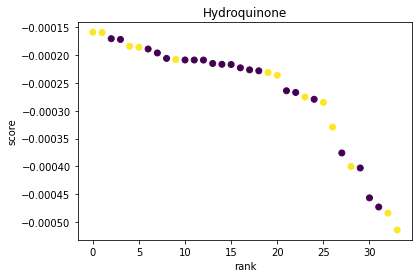

(34, 514)


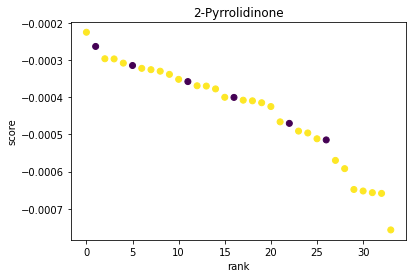

(34, 514)


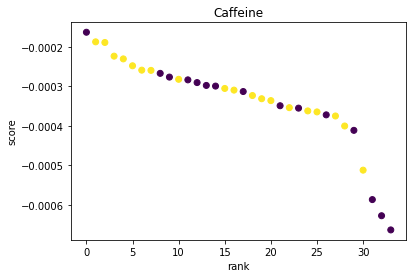

(34, 514)


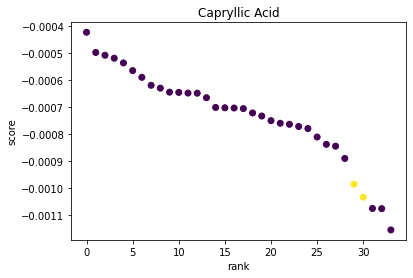

(34, 514)


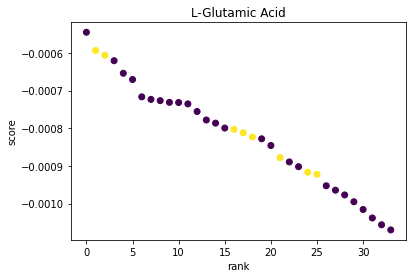

(34, 514)


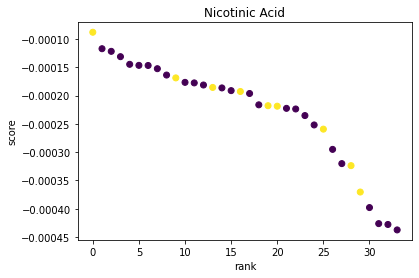

(34, 514)


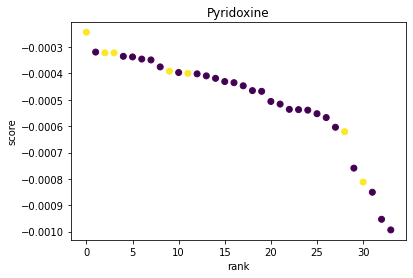

(34, 514)


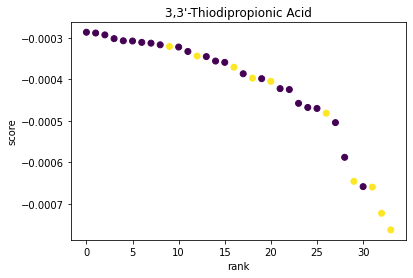

(34, 514)


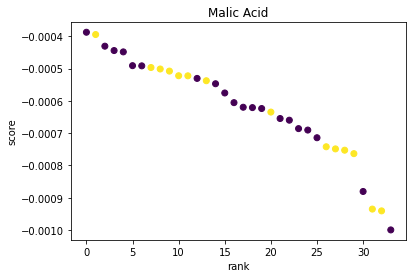

(34, 514)


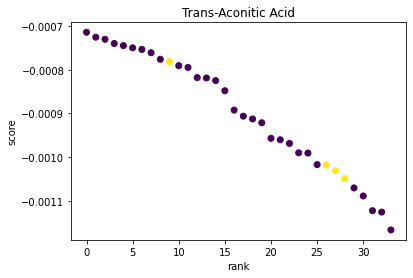

(34, 514)


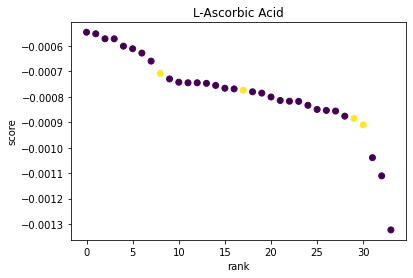

(34, 514)


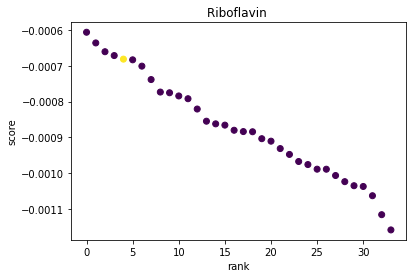

In [ ]:
# Evaluate per API
api_list= rc_df[['Name 1']].drop_duplicates(['Name 1']).values.ravel()

for i in api_list[:]:
  mc_df =rc_df[rc_df['Name 1']==i]
  score_mc = score(deep_SVDD, mc_df.iloc[:,2:].values).cpu().detach().numpy()
  #print(score_mc)
  #score_mc = clf.decision_function(mc_df.iloc[:,2:].values)*-1
  true_label = rc_label.loc[mc_df.index]
  roc_auc_mc = roc_auc_score(true_label, score_mc)
  #print(i, roc_auc_mc)
  plot_apis(i)

In [ ]:
def plot_apis(api):

  test = grecu_df[grecu_df['Name 1']==i]
  test_label = label.iloc[test.index]
  rc = score(deep_SVDD, test.iloc[:,2:].values).cpu().detach().numpy()*-1
  rc1 = rc  #y_scaler1.transform(rc.reshape(-1,1))
  rc_validation=pd.concat([pd.DataFrame(rc1, columns=['score']), pd.DataFrame(test_label.values, columns=['color'])], axis=1)
  rc_val_sort = rc_validation.sort_values(by='score', ascending=False)
  x=np.arange(len(rc1))
  plt.scatter(x ,rc_val_sort.score, c=rc_val_sort.color, cmap='viridis')
  #plt.ylim(0,1)
  #plt.axhline(y=0.8, label='Threshold', c='r', linewidth=4)
  plt.ylabel('score')
  plt.xlabel('rank')
  plt.title('%s'%api)
  plt.show()

diclofenac 0.8857142857142857


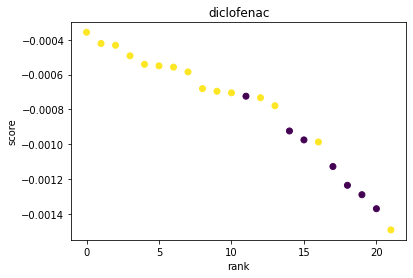

piracetam 0.7157894736842105


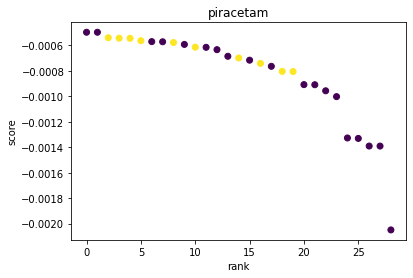

pyrazine carboxamide 0.5904761904761905


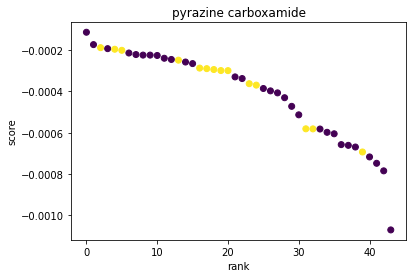

acetazolamide 0.3666666666666667


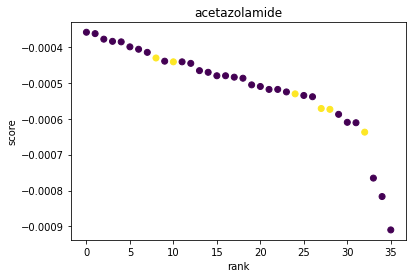

indomethacin 0.5185185185185184


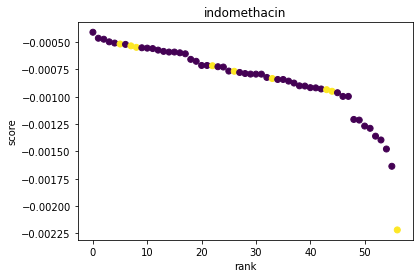

drug candidate 0.8435374149659864


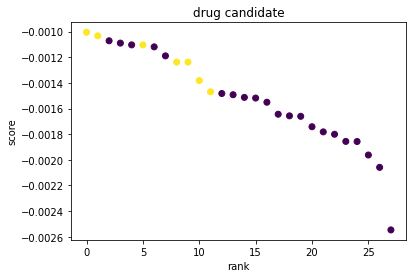

furosemide 0.6125


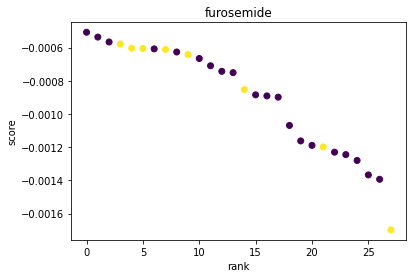

nalidixic acid 0.6666666666666666


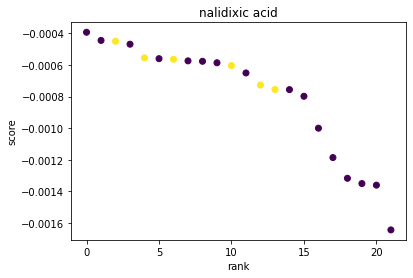

paracetamol 0.42708333333333337


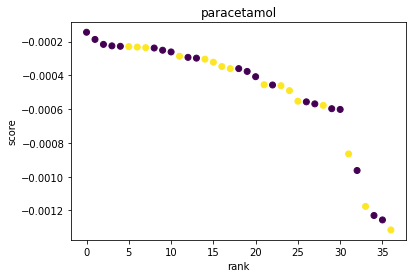

3-cyanophenol  0.8444444444444446


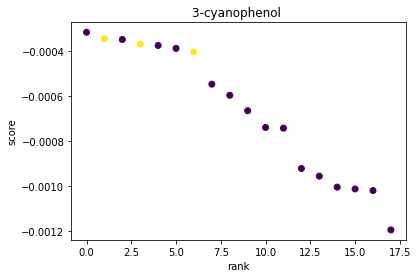

4-cyanophenol 0.9642857142857143


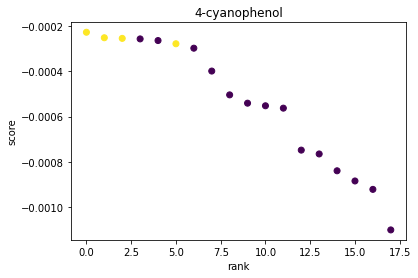

3-cyanopyridine 0.5882352941176471


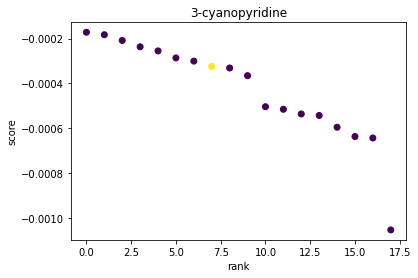

4-cyanopyridine 0.6410256410256411


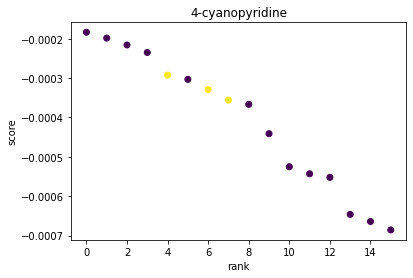

benzamide  0.6


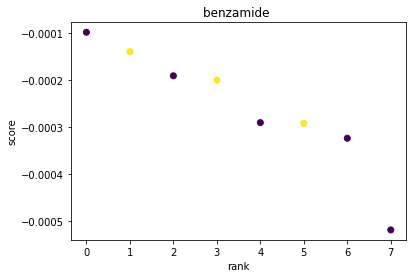

itraconazole  0.34375


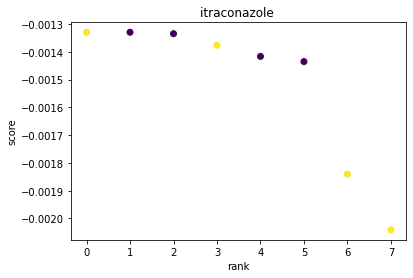

bicalutamide  0.9375


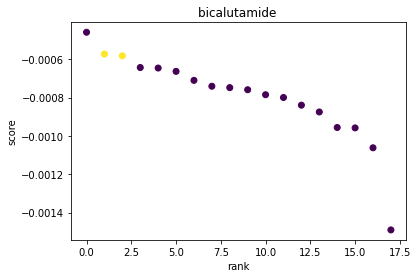

meloxicam  0.6071428571428571


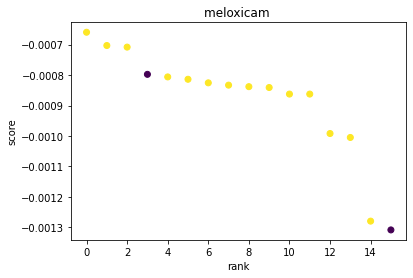

nicotinamide  0.7500000000000001


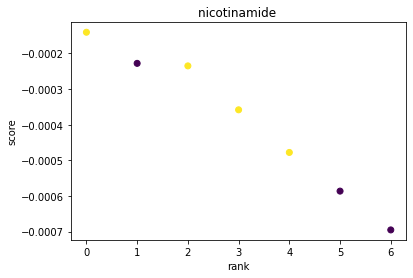

loratadine 0.7612903225806452


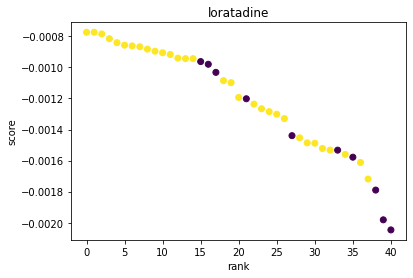

desloratadine 0.6785714285714286


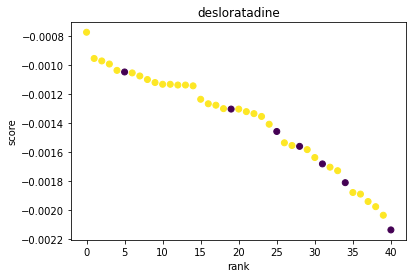

In [ ]:
# Evaluate per API
api_list= grecu_df[['Name 1']].drop_duplicates(['Name 1']).values.ravel()

for i in api_list[:]:
  mc_df =grecu_df[grecu_df['Name 1']==i]
  score_mc = -1*score(deep_SVDD, mc_df.iloc[:,2:].values).cpu().detach().numpy()
  #score_mc = clf.decision_function(mc_df.iloc[:,2:].values)*-1
  true_label = label.loc[mc_df.index]
  try:
    roc_auc_mc = roc_auc_score(true_label, score_mc)
    print(i, roc_auc_mc)
    plot_apis(i)
  except:
    pass